In [546]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import powerlaw


from pm4py.objects.conversion.log import converter as log_converter
from pm4py.statistics.variants.log import get as variants_get
from pm4py.statistics.variants.log import get as variants_get_traces
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.statistics.end_activities.log import get as end_activities_get
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from itertools import combinations
from scipy import stats
from scipy.stats import wasserstein_distance
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.statistics.start_activities.log import get as start_activities
from pm4py.statistics.end_activities.log import get as end_activities

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

from pm4py.algo.filtering.log.variants import variants_filter as variants_filter_module


from scipy.stats import kruskal


In [547]:

# Load dataset (modify the file path if needed)
filepath = '/home/angela/Desktop/BIS/Exam Project/BrazilianHREventLog/UpFLux_Healthcare_Database_labeled.csv'
df = pd.read_csv(filepath, parse_dates=["time:timestamp"])
df['case:concept:name'] = df['case:concept:name'].astype(str)

print(df.dtypes)

df

case:concept:name             object
Idade                          int64
Sexo                          object
Nível de Urgência             object
CID                           object
Médico Responsável            object
Doença                        object
Data Inicial                  object
time:timestamp        datetime64[ns]
concept:name                  object
Item                          object
Data Prescrição               object
Tempo Processo               float64
Setor                         object
Quantidade                   float64
Retorno                       object
Multipassante                 object
Convênio                      object
outlier_label                 object
dtype: object


,case:concept:name,Idade,Sexo,Nível de Urgência,CID,Médico Responsável,Doença,Data Inicial,time:timestamp,concept:name,Item,Data Prescrição,Tempo Processo,Setor,Quantidade,Retorno,Multipassante,Convênio,outlier_label
0,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:22,2020-07-21 10:22:00,Atendimento,Atendimento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,Não,Convênio 9,outlier
1,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:45,2020-07-21 10:49:00,Triagem,Triagem,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier
2,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:01,2020-07-21 11:01:00,Exames Laboratoriais,Coronavírus COVID-19 - Diagnóstico Molecular (...,21/07/2020 10:51,9.0,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier
3,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:32,2020-07-21 11:32:00,Consulta,Consulta,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier
4,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 19:27,2020-07-21 19:27:00,Alta,Alta para completar tratamento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Equipo Primeline Air IL (ref.401450p) (cx c/8...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier
3089,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Cateter Perif. SAFETY 22G (cx c/200) ref. 425...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier
3090,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Seringa descartavel 10ml Luer Lok (cx c/ 100) ...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier
3091,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Agulha descartavel 40x12 (cx.c/100) (300017) - BD,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier


In [548]:
display(df.isnull().sum()[df.isnull().sum() > 0])

Data Inicial          2
time:timestamp       18
Data Prescrição    2715
Tempo Processo     2716
Quantidade          155
Multipassante      2650
dtype: int64

# Prepare (Filtering) the DataFrame and Event Log for Start Analyzing


### Step 1: Data Quality Assessment

In [549]:
# Convert DataFrame to pm4py event log
# pm4py expects specific column names: case:concept:name, concept:name, time:timestamp
event_log = log_converter.apply(df, 
                                 variant=log_converter.Variants.TO_EVENT_LOG)

# Check for duplicate events
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Examine unique values in key columns
print(f"Number of unique patients (cases): {df['case:concept:name'].nunique()}")
print(f"Number of unique activities: {df['concept:name'].nunique()}")
print(f"\nActivity Distribution:")
print(df['concept:name'].value_counts())

# Check outlier_label distribution
print("Outlier Label Distribution:")
print(df['outlier_label'].value_counts())



Number of duplicate rows: 4
Number of unique patients (cases): 443
Number of unique activities: 9

Activity Distribution:
concept:name
Medicamentos                 494
Materiais Hospitalares       455
Atendimento                  443
Alta                         443
Consulta                     443
Triagem                      437
Exames Laboratoriais         223
Exames de Imagem             133
Exames Eletrofisiológicos     22
Name: count, dtype: int64
Outlier Label Distribution:
outlier_label
inlier     2689
outlier     404
Name: count, dtype: int64


### Step 2: Timestamp Parsing & Validation

In [550]:
# Check and convert time:timestamp into datetime before start processing 
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])


# Check for parsing errors
invalid_timestamps = df['time:timestamp'].isnull().sum()
print(f"Invalid timestamps: {invalid_timestamps}")

# Check for cases with missing Timestamp.
total_cases = df['case:concept:name'].nunique()
total_events = len(df)
cases_with_missing_timestamps = df[df['time:timestamp'].isna()]['case:concept:name'].nunique()
print(f"   • Cases with missing timestamps: {cases_with_missing_timestamps} ({cases_with_missing_timestamps/total_cases*100:.2f}%)")
    
# Check for missing "Tempo Processo"
missing_tempo = df['Tempo Processo'].isna().sum()
print(f"   • Missing 'Tempo Processo': {missing_tempo} ({missing_tempo/total_events*100:.2f}%)")
    

# Sort by Case ID and time:timestamp
df = df.sort_values(['case:concept:name', 'time:timestamp'])

Invalid timestamps: 18
   • Cases with missing timestamps: 17 (3.84%)
   • Missing 'Tempo Processo': 2716 (87.81%)


#### Some analysis of the invalid timestamp and clean NULL values

In [551]:
# STEP 1: Assess the impact
total_events = len(df)
invalid_count = df['time:timestamp'].isnull().sum()
percentage_invalid = (invalid_count / total_events) *100

print(f"Invalid timestamps: {invalid_count} ({percentage_invalid:.2f}%)")

# STEP 2: Check which cases are affected
cases_with_invalid = df[df['time:timestamp'].isnull()]['case:concept:name'].nunique()
total_cases = df['case:concept:name'].nunique()

print(f"Cases affected: {cases_with_invalid} out of {total_cases}")

# STEP 3: Make decision based on impact
if percentage_invalid < 0.1:
    print("✓ Low impact, Safe to remove")
    action = "DELETE"
elif percentage_invalid < 0.59:
    print("Moderate impact, Investigate but likely DELETE")
    action = "DELETE with documentation"
else:
    print("High impact, Investigate data quality issues")
    action = "DELETE but report data quality problem"


Invalid timestamps: 18 (0.58%)
Cases affected: 17 out of 443
Moderate impact, Investigate but likely DELETE


In [552]:
invalid_events = df[df['time:timestamp'].isnull()].copy()
print("Invalid events analysis:\n",invalid_events[['case:concept:name', 'concept:name', 'Doença']].head())
display(invalid_events['concept:name'].value_counts())


# Clean the dataset
df_clean = df.dropna(subset=['time:timestamp'])


# Make sure you didn't lose entire cases
cases_before = df['case:concept:name'].nunique()
cases_after = df_clean['case:concept:name'].nunique()

print(f"Cases before: {cases_before}")
print(f"Cases after: {cases_after}")
print(f"Cases lost: {cases_before - cases_after}")


display(df_clean)

df = df_clean.copy()


Invalid events analysis:
     case:concept:name concept:name  \
56            5446886      Triagem   
118           5446991      Triagem   
135           5447008      Triagem   
331           5448329      Triagem   
345           5448376      Triagem   

                                                Doença  
56   J11.1 Influenza c/out manif resp dev virus n i...  
118  J11.1 Influenza c/out manif resp dev virus n i...  
135  J11.1 Influenza c/out manif resp dev virus n i...  
331  J11.1 Influenza c/out manif resp dev virus n i...  
345  J11.1 Influenza c/out manif resp dev virus n i...  


concept:name
Triagem                      16
Consulta                      1
Exames Eletrofisiológicos     1
Name: count, dtype: int64

Cases before: 443
Cases after: 443
Cases lost: 0


,case:concept:name,Idade,Sexo,Nível de Urgência,CID,Médico Responsável,Doença,Data Inicial,time:timestamp,concept:name,Item,Data Prescrição,Tempo Processo,Setor,Quantidade,Retorno,Multipassante,Convênio,outlier_label
0,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:22,2020-07-21 10:22:00,Atendimento,Atendimento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,Não,Convênio 9,outlier
1,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:45,2020-07-21 10:49:00,Triagem,Triagem,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier
2,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:01,2020-07-21 11:01:00,Exames Laboratoriais,Coronavírus COVID-19 - Diagnóstico Molecular (...,21/07/2020 10:51,9.0,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier
3,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:32,2020-07-21 11:32:00,Consulta,Consulta,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier
4,5446538,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 19:27,2020-07-21 19:27:00,Alta,Alta para completar tratamento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Equipo Primeline Air IL (ref.401450p) (cx c/8...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier
3089,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Cateter Perif. SAFETY 22G (cx c/200) ref. 425...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier
3090,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Seringa descartavel 10ml Luer Lok (cx c/ 100) ...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier
3091,5463012,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Agulha descartavel 40x12 (cx.c/100) (300017) - BD,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier


### Step 3: Activity frequency analysis


In [553]:
# Activity frequency analysis
print(f"ACTIVITY ANALYSIS:")
activity_counts = df['concept:name'].value_counts()
print(f"Number of unique activities: {len(activity_counts)}")
print(f"Most frequent activity: '{activity_counts.index[0]}' ({activity_counts.iloc[0]} occurrences)")
print(f"Least frequent activity: '{activity_counts.index[-1]}' ({activity_counts.iloc[-1]} occurrences)")

# Infrequent activities (appearing in < 1% of cases)
threshold = total_cases * 0.01
infrequent_activities = activity_counts[activity_counts < threshold]
print(f"Activities occurring in < 1% of cases: {len(infrequent_activities)}")



# Check for incomplete cases (cases with only 1 event)
print(f"CASE COMPLETENESS ANALYSIS:")
case_lengths = df.groupby('case:concept:name').size()
single_event_cases = (case_lengths == 1).sum()
print(f"Cases with only 1 event: {single_event_cases} ({single_event_cases/total_cases*100:.2f}%)")
print(f"Average case length: {case_lengths.mean():.2f} events")
print(f"Median case length: {case_lengths.median():.0f} events")



ACTIVITY ANALYSIS:
Number of unique activities: 9
Most frequent activity: 'Medicamentos' (494 occurrences)
Least frequent activity: 'Exames Eletrofisiológicos' (21 occurrences)
Activities occurring in < 1% of cases: 0
CASE COMPLETENESS ANALYSIS:
Cases with only 1 event: 0 (0.00%)
Average case length: 6.94 events
Median case length: 4 events


In [554]:
# Filter Infrequent Activities
# Remove infrequent activities (noise)
def filter_infrequent_activities(df, min_frequency=3):
    initial_events = len(df)
    initial_cases = df['case:concept:name'].nunique()
    
    # Count activity frequencies
    activity_counts = df['concept:name'].value_counts()
    frequent_activities = activity_counts[activity_counts >= min_frequency].index
    
    # Filter to keep only frequent activities
    df_filtered = df[df['concept:name'].isin(frequent_activities)].copy()
    
    removed_activities = len(activity_counts) - len(frequent_activities)
    removed_events = initial_events - len(df_filtered)
    
    print(f"✓ Removed {removed_activities} infrequent activities")
    print(f"✓ Removed {removed_events} events")
    print(f"✓ Remaining: {len(df_filtered)} events in {df_filtered['case:concept:name'].nunique()} cases")
    
    return df_filtered


In [555]:
df_temp = filter_infrequent_activities(df, min_frequency=3)

✓ Removed 0 infrequent activities
✓ Removed 0 events
✓ Remaining: 3075 events in 443 cases


In [556]:
df = df_temp.copy()


### Step 4: Cases frequency analysis

In [557]:
def filter_cases_with_missing_critical_attributes(df, critical_attributes):
    print("REMOVING CASES WITH MISSING CRITICAL ATTRIBUTES")
    
    initial_events = len(df)
    initial_cases = df['case:concept:name'].nunique()
    
    # Find cases where any critical attribute is missing
    cases_to_remove = set()
    
    for attr in critical_attributes:
        if attr in df.columns:
            missing_mask = df[attr].isna()
            affected_cases = df[missing_mask]['case:concept:name'].unique()
            cases_to_remove.update(affected_cases)
            print(f"   • Found {len(affected_cases)} cases with missing '{attr}'")
    
    # Filter out cases with missing critical attributes
    df_filtered = df[~df['case:concept:name'].isin(cases_to_remove)].copy()
    
    removed_cases = len(cases_to_remove)
    removed_events = initial_events - len(df_filtered)
    
    print(f"✓ Removed {removed_cases} cases with missing critical attributes")
    print(f"✓ Removed {removed_events} events")
    print(f"✓ Remaining: {len(df_filtered)} events in {df_filtered['case:concept:name'].nunique()} cases")
    
    return df_filtered


In [558]:
df_temp = filter_cases_with_missing_critical_attributes(df, ['concept:name', 'time:timestamp'])

REMOVING CASES WITH MISSING CRITICAL ATTRIBUTES
   • Found 0 cases with missing 'concept:name'
   • Found 0 cases with missing 'time:timestamp'
✓ Removed 0 cases with missing critical attributes
✓ Removed 0 events
✓ Remaining: 3075 events in 443 cases


In [559]:
df = df_temp.copy()


### Step 5: Case-Level Quality Checks

In [560]:
# Analyze case characteristics
case_stats = df.groupby('case:concept:name').agg({
    'concept:name': 'count',  # Events per case
    'time:timestamp': ['min', 'max']  # Case start and end
}).reset_index()


case_stats.columns = ['case_id', 'num_events', 'start_time', 'end_time']
case_stats['case_duration'] = (case_stats['end_time'] - case_stats['start_time']).dt.total_seconds() / 3600  # hours

print("Case Statistics:\n",case_stats[['num_events', 'case_duration']].describe())


# Identify potential problematic cases
print("Cases with only 2 event:",case_stats[case_stats['num_events'] == 2].shape[0])

# Identify potential problematic duration 
duration_threshold = case_stats['case_duration'].quantile(0.99)
print("\nCases with unusually long duration (> 99th percentile):",case_stats[case_stats['case_duration'] > duration_threshold].shape[0])




Case Statistics:
        num_events  case_duration
count  443.000000     443.000000
mean     6.941309       2.216892
std      6.165235       3.269520
min      3.000000       0.133333
25%      4.000000       0.783333
50%      4.000000       1.383333
75%      6.000000       2.666667
max     60.000000      53.683333
Cases with only 2 event: 0

Cases with unusually long duration (> 99th percentile): 5


### Step 6: Clinical Context Analysis

In [561]:
# Analyze clinical attributes
print("Disease Distribution (Top 10):")
print(df.groupby('case:concept:name')['Doença'].first().value_counts().head(10))

print("\n" + "="*50)
print("Discharge/Return Type Distribution:")
retorno_series = df.groupby('case:concept:name')['Retorno'].first().value_counts()
print(retorno_series.to_frame().assign(
    Percentage=lambda x: (x['count'] / x['count'].sum() * 100).round(1).astype(str) + '%'
))

# Correlate outlier_label with clinical outcomes
clinical_outlier = df.groupby('case:concept:name').agg({
    'outlier_label': 'first',
    'Doença': 'first',
    'Retorno': 'first'
}).reset_index()

print("\n" + "="*50)
print("Outlier Distribution by Discharge Type:")
display(pd.crosstab(clinical_outlier['outlier_label'], clinical_outlier['Retorno']))

Disease Distribution (Top 10):
Doença
J11.1 Influenza c/out manif resp dev virus n ident    351
N23   Colica nefretica NE                              47
R07.4 Dor toracica NE                                  32
R07.3 Outr dor toracica                                 5
I64   Acid vasc cerebr NE como hemorrag isquemico       4
J12.9 Pneumonia viral NE                                3
J10.1 Influenz c/out manif resp dev vir infl ident      1
Name: count, dtype: int64

Discharge/Return Type Distribution:
                         count Percentage
Retorno                                  
Sem retorno                418      94.4%
Retorno em menos 24h        11       2.5%
Retorno entre 24h e 48h      8       1.8%
Retorno entre 48h e 72h      6       1.4%

Outlier Distribution by Discharge Type:


Retorno,Retorno em menos 24h,Retorno entre 24h e 48h,Retorno entre 48h e 72h,Sem retorno
outlier_label,,,,
inlier,9,7,6,394
outlier,2,1,0,24


In [562]:
# Analyze resource involvement
print("Top 10 Most Active Resources (Médico Responsável):")
print(df['Médico Responsável'].value_counts().head(10))

print("\n" + "="*50)
print("Most Common Items/Medications:")
print(df['Item'].value_counts().head(15))

# Check for missing resource/item data
print("\n" + "="*50)
print(f"Events with missing Médico Responsável: {df['Médico Responsável'].isnull().sum()}")
print(f"Events with missing Item: {df['Item'].isnull().sum()}")

Top 10 Most Active Resources (Médico Responsável):
Médico Responsável
Médico 72    906
Médico 58    500
Médico 22    372
Médico 55    211
Médico 15    156
Médico 25     86
Médico 75     83
Médico 63     80
Médico 2      72
Médico 84     69
Name: count, dtype: int64

Most Common Items/Medications:
Item
Atendimento                                                          443
Consulta                                                             442
Alta para completar tratamento                                       427
Triagem                                                              421
Agulha descartavel 40x12 (cx.c/100) (300017) - BD                    100
Seringa descartavel 10ml Luer Lok (cx c/ 100) (990172) - BD           94
Equipo Primeline Air IL  (ref.401450p) (cx c/80) - B.Braun            84
Cateter Perif. SAFETY 22G (cx c/200)  ref. 4251628-04) -  B Braun     79
RX Tórax - 1 Incidência (P.A.)                                        61
Soro Fisiologico 0,9% 100mL (cx 80) -Fre

# Activity Frequency Analysis 

### Step 1: Activity Frequency Analysis 

In [563]:
# Compute frequency of activities

activity_counts = df["concept:name"].value_counts()
print(f"\nTotal unique activities in the process: {len(activity_counts)}\n")

# Display the activity frequencies
print("Frequency of Activities (sorted by occurrence):\n",activity_counts)


print("ACTIVITY STATISTICS:")
print(f"{'='*80}")
print(f"Most frequent activity: '{activity_counts.index[0]}' ({activity_counts.iloc[0]:,} times)")
print(f"Least frequent activity: '{activity_counts.index[-1]}' ({activity_counts.iloc[-1]:,} times)")
print(f"Average activity frequency: {activity_counts.mean():.2f}")
print(f"Median activity frequency: {activity_counts.median():.2f}")



print(f"\n{'='*80}")
print("TOP 10 ACTIVITIES BY PERCENTAGE:")
print(f"{'='*80}")
activity_percentages = (activity_counts / activity_counts.sum() * 100).sort_values(ascending=False).head(10)
for idx, (activity, percentage) in enumerate(activity_percentages.items(), 1):
    print(f"{idx:2d}. {activity:<40} {percentage:6.2f}%")


Total unique activities in the process: 9

Frequency of Activities (sorted by occurrence):
 concept:name
Medicamentos                 494
Materiais Hospitalares       455
Atendimento                  443
Alta                         443
Consulta                     442
Triagem                      421
Exames Laboratoriais         223
Exames de Imagem             133
Exames Eletrofisiológicos     21
Name: count, dtype: int64
ACTIVITY STATISTICS:
Most frequent activity: 'Medicamentos' (494 times)
Least frequent activity: 'Exames Eletrofisiológicos' (21 times)
Average activity frequency: 341.67
Median activity frequency: 442.00

TOP 10 ACTIVITIES BY PERCENTAGE:
 1. Medicamentos                              16.07%
 2. Materiais Hospitalares                    14.80%
 3. Atendimento                               14.41%
 4. Alta                                      14.41%
 5. Consulta                                  14.37%
 6. Triagem                                   13.69%
 7. Exames Lab

### Step 2: Activity Frequency Visualization 

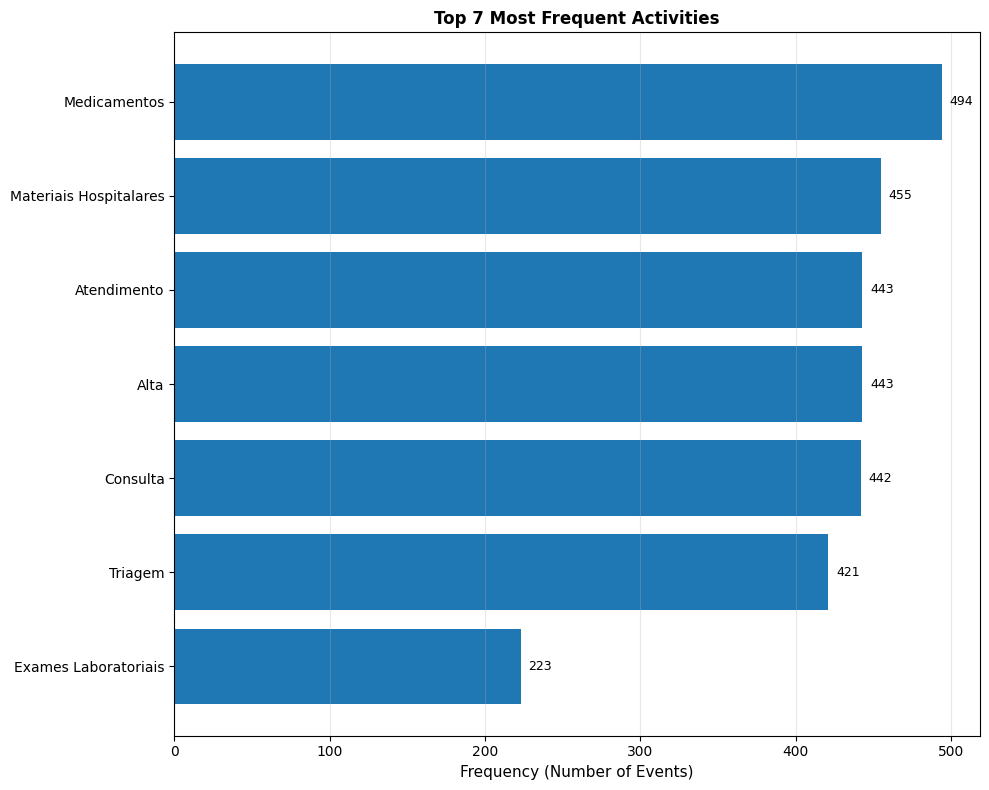

In [564]:
# Visualize activity distribution (Top 7 only)

plt.figure(figsize=(10, 8))

# Select top 
top_n = 7
top_activities = activity_counts.head(top_n)

# Bar chart
plt.barh(range(len(top_activities)), top_activities.values)
plt.yticks(range(len(top_activities)), top_activities.index, fontsize=10)
plt.xlabel('Frequency (Number of Events)', fontsize=11)
plt.title(f'Top {top_n} Most Frequent Activities', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add labels on bars
for i, v in enumerate(top_activities.values):
    plt.text(v + max(top_activities.values)*0.01, i, f'{v:,}',
             va='center', fontsize=9)

plt.tight_layout()
plt.show()


# Variant Analysis Introduction 


### Step 1: Extract Variants 

In [565]:
# Extract variants from the event log
variants = variants_get.get_variants(event_log)

print(f"Total unique variants: {len(variants)}")
print(f"Total cases: {len(event_log)}")


# Create a summary DataFrame for easier analysis
variant_summary = []

for variant_str, trace_list in variants.items():
    variant_summary.append({
        'variant': variant_str,
        'frequency': len(trace_list),
        'percentage': (len(trace_list) / len(event_log)) * 100,
    })



# Convert to DataFrame and sort by frequency
variant_df = pd.DataFrame(variant_summary)
variant_df = variant_df.sort_values('frequency', ascending=False).reset_index(drop=True)
variant_df['cumulative_percentage'] = variant_df['percentage'].cumsum()

# Add variant index starting from 1 for the most frequent
variant_df["variant_index"] = variant_df.index + 1

# Add variant lenght 
variant_df["variant_length"] = [len(variant) for variant in variant_df["variant"]]
top5_coverage = variant_df["percentage"].head(5).sum()


print(f"Top 5 variants cover: {top5_coverage:.2f}% of traces")
display(variant_df)

Total unique variants: 111
Total cases: 443
Top 5 variants cover: 72.23% of traces


,variant,frequency,percentage,cumulative_percentage,variant_index,variant_length
0,"(Atendimento, Triagem, Consulta, Alta)",247,55.756208,55.756208,1,4
1,"(Atendimento, Triagem, Consulta, Exames de Ima...",49,11.060948,66.817156,2,5
2,"(Atendimento, Triagem, Consulta, Exames Labora...",12,2.708804,69.525959,3,5
3,"(Atendimento, Triagem, Consulta, Exames Labora...",8,1.805869,71.331828,4,7
4,"(Atendimento, Triagem, Consulta, Exames Labora...",4,0.902935,72.234763,5,6
...,...,...,...,...,...,...
106,"(Atendimento, Triagem, Consulta, Materiais Hos...",1,0.225734,99.097065,107,16
107,"(Atendimento, Triagem, Consulta, Exames Labora...",1,0.225734,99.322799,108,9
108,"(Atendimento, Consulta, Triagem, Materiais Hos...",1,0.225734,99.548533,109,10
109,"(Atendimento, Consulta, Medicamentos, Exames L...",1,0.225734,99.774266,110,6


### Step 2: Variant Statistics

In [566]:
# Display top 10 most frequent variants
print(f"TOP 10 MOST FREQUENT VARIANTS")

top_10 = variant_df.head(10).copy()

# Format for better display
top_10_display = top_10[['frequency', 'percentage', 'cumulative_percentage', 'variant_length']].copy()
top_10_display.columns = ['Cases', 'Percentage (%)', 'Cumulative (%)', 'Activities']
top_10_display['Percentage (%)'] = top_10_display['Percentage (%)'].round(2)
top_10_display['Cumulative (%)'] = top_10_display['Cumulative (%)'].round(2)

#print(top_10_display)
display(top_10_display)

# Show the actual activity sequences for top 3
print(f"ACTIVITY SEQUENCES OF TOP 3 VARIANTS:")
for idx in range(min(3, len(variant_df))):
    print(f"\nVariant #{idx+1} ({variant_df.iloc[idx]['frequency']} cases, "
          f"{variant_df.iloc[idx]['percentage']:.2f}%):")
    activities = variant_df.iloc[idx]['variant']
    for i, activity in enumerate(activities, 1):
        print(f"   {i}. {activity.strip()}")

TOP 10 MOST FREQUENT VARIANTS


,Cases,Percentage (%),Cumulative (%),Activities
0,247,55.76,55.76,4
1,49,11.06,66.82,5
2,12,2.71,69.53,5
3,8,1.81,71.33,7
4,4,0.90,72.23,6
5,4,0.90,73.14,14
6,3,0.68,73.81,5
7,3,0.68,74.49,5
8,3,0.68,75.17,4
9,2,0.45,75.62,14


ACTIVITY SEQUENCES OF TOP 3 VARIANTS:

Variant #1 (247 cases, 55.76%):
   1. Atendimento
   2. Triagem
   3. Consulta
   4. Alta

Variant #2 (49 cases, 11.06%):
   1. Atendimento
   2. Triagem
   3. Consulta
   4. Exames de Imagem
   5. Alta

Variant #3 (12 cases, 2.71%):
   1. Atendimento
   2. Triagem
   3. Consulta
   4. Exames Laboratoriais
   5. Alta


### Step 3: Variant Complexity Analysis

       count_of_cases  count_of_variants
count       28.000000          28.000000
mean        15.821429           3.964286
std         48.382774           3.553633
min          1.000000           1.000000
25%          1.000000           1.000000
50%          3.000000           2.500000
75%          7.750000           5.000000
max        252.000000          13.000000
............................................................
FREQUENCY vs COMPLEXITY:
                frequency  num_variants  percentage
variant_length                                     
4                     252             3   56.884876
5                      76            11   17.155756
6                       7             4    1.580135
7                      12             5    2.708804
8                       3             2    0.677201
9                       4             4    0.902935
10                      4             4    0.902935
11                      6             6    1.354402
12                      6

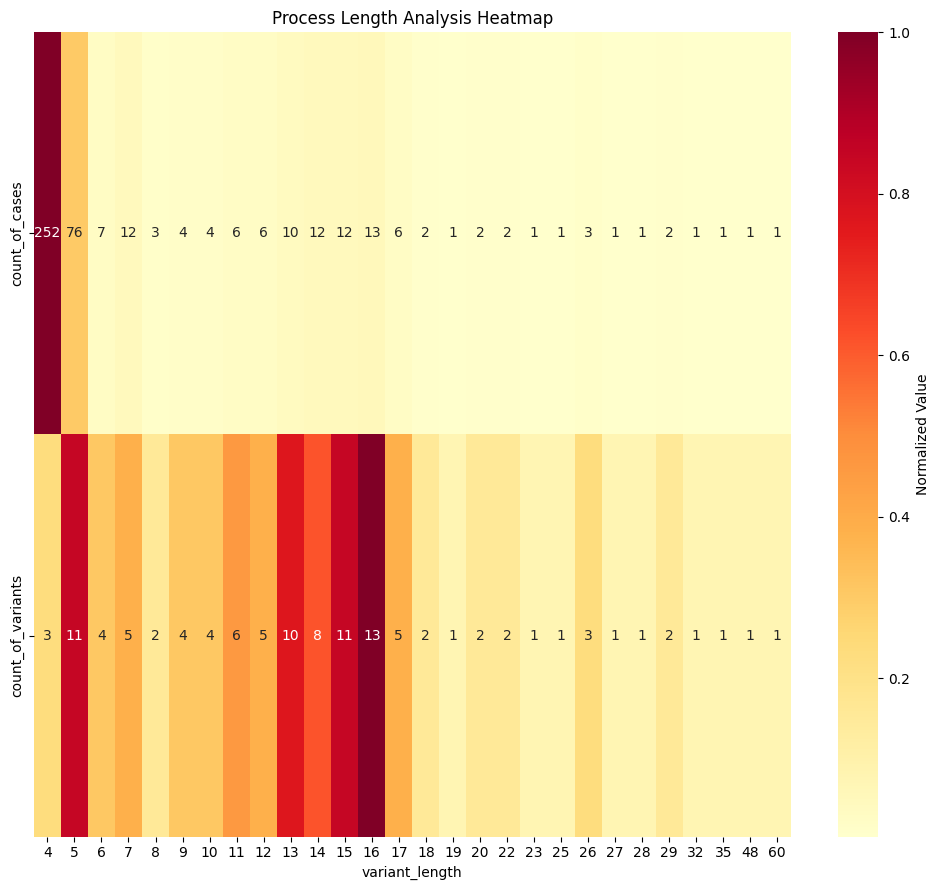

In [567]:
# Length and number of cases

length_analysis = variant_df.groupby("variant_length").agg({
    "frequency": "sum",
    "variant_index": "count"
}).rename(columns={"variant_index": "count_of_variants", "frequency": "count_of_cases"}) 

print(length_analysis.describe())


# Frequency vs Length analysis
# Group by length to see patterns
length_freq = variant_df.groupby('variant_length').agg({
    'frequency': 'sum',
    'variant': 'count'
}).rename(columns={'variant': 'num_variants'})

length_freq['percentage'] = (length_freq['frequency'] / len(event_log)) * 100

print(f"{'.'*60}")
print(f"FREQUENCY vs COMPLEXITY:")

print(length_freq.head(10))


# A heatmap
plt.figure(figsize=(10, 9))
# Normalize data for better heatmap visualization
normalized_data = length_analysis.apply(lambda x: x/x.max(), axis=0)

sns.heatmap(normalized_data.T, annot=length_analysis.T, fmt='d',
            cmap='YlOrRd', cbar_kws={'label': 'Normalized Value'})
plt.title('Process Length Analysis Heatmap')
plt.tight_layout()
plt.show()

### Step 4: Filter By Variant Length

In [568]:
# FILTERING BY VARIANT LENGTH (Removing Incomplete/Abnormal cases)
Q1 = variant_df['variant_length'].quantile(0.25)
Q3 = variant_df['variant_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = max(1, Q1 - 1.5 * IQR)  
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound: {lower_bound:.1f}")
print(f"Upper bound: {upper_bound:.1f}")

min_length = lower_bound
max_length = upper_bound

## Apply filtering
mask = (variant_df['variant_length'] >= min_length) if min_length else pd.Series([True] * len(variant_df))
if max_length is not None:
    mask &= (variant_df['variant_length'] <= max_length)

variants_to_keep = variant_df[mask]['variant'].tolist()
filtered_log = variants_filter.apply(df, variants_to_keep)

# Convert to DataFrame if needed (pm4py sometimes returns EventLog objects)
if not isinstance(filtered_log, pd.DataFrame):
    filtered_log = pm4py.convert_to_dataframe(filtered_log)

# Statistics - CORRECTED
original_events = len(df)
original_cases = df['case:concept:name'].nunique()

filtered_events = len(filtered_log)
filtered_cases = filtered_log['case:concept:name'].nunique()

events_removed = original_events - filtered_events
cases_removed = original_cases - filtered_cases
removal_pct = (cases_removed / original_cases) * 100 


print(f"Original: {original_cases} cases, {original_events} events")
print(f"Filtered: {filtered_cases} cases, {filtered_events} events")
print(f"Removed: {cases_removed} cases ({removal_pct:.2f}%)")
print(f"Removed: {events_removed} events")

print(f"{'='*50}")
outlier_cases = variant_df[(variant_df['variant_length'] < lower_bound) | 
                            (variant_df['variant_length'] > upper_bound)]
print("Outlier variants being removed:")
display(outlier_cases[['variant', 'variant_length', 'frequency']])


display(filtered_log)

Q1 (25th percentile): 9.0
Q3 (75th percentile): 16.0
IQR: 7.0
Lower bound: 1.0
Upper bound: 26.5
Original: 443 cases, 3075 events
Filtered: 418 cases, 2678 events
Removed: 25 cases (5.64%)
Removed: 397 events
Outlier variants being removed:


,variant,variant_length,frequency
25,"(Atendimento, Triagem, Exames Eletrofisiológic...",48,1
32,"(Atendimento, Consulta, Medicamentos, Materiai...",27,1
35,"(Atendimento, Triagem, Consulta, Materiais Hos...",29,1
42,"(Atendimento, Triagem, Materiais Hospitalares,...",60,1
58,"(Atendimento, Triagem, Consulta, Materiais Hos...",35,1
77,"(Atendimento, Consulta, Medicamentos, Materiai...",32,1
90,"(Atendimento, Triagem, Consulta, Medicamentos,...",28,1
93,"(Atendimento, Consulta, Materiais Hospitalares...",29,1


,Idade,Sexo,Nível de Urgência,CID,Médico Responsável,Doença,Data Inicial,time:timestamp,concept:name,Item,Data Prescrição,Tempo Processo,Setor,Quantidade,Retorno,Multipassante,Convênio,outlier_label,case:concept:name
0,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:22,2020-07-21 10:22:00,Atendimento,Atendimento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,Não,Convênio 9,outlier,5446538
1,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:45,2020-07-21 10:49:00,Triagem,Triagem,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538
2,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:01,2020-07-21 11:01:00,Exames Laboratoriais,Coronavírus COVID-19 - Diagnóstico Molecular (...,21/07/2020 10:51,9.0,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier,5446538
3,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:32,2020-07-21 11:32:00,Consulta,Consulta,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538
4,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 19:27,2020-07-21 19:27:00,Alta,Alta para completar tratamento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2673,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Equipo Primeline Air IL (ref.401450p) (cx c/8...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier,5463012
2674,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Cateter Perif. SAFETY 22G (cx c/200) ref. 425...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier,5463012
2675,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Seringa descartavel 10ml Luer Lok (cx c/ 100) ...,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier,5463012
2676,45,F,Média,N23,Médico 55,N23 Colica nefretica NE,05/08/2020 05:22,2020-08-05 05:22:00,Materiais Hospitalares,Agulha descartavel 40x12 (cx.c/100) (300017) - BD,NaN,NaN,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,inlier,5463012


In [569]:
# Because the result is convinces I will update the DF also

df = pm4py.convert_to_dataframe(filtered_log)
print(f"number of cases now {df['case:concept:name'].nunique()}")


number of cases now 418


### Step 5: Filter Incomplete Cases

In [570]:
# First analyse the Start and end activity for the cases

# Get start and end activities with their frequencies
start_activities = start_activities_get.get_start_activities(df)
end_activities = end_activities_get.get_end_activities(df)



print('start_activities \n', start_activities)
print('end_activities \n', end_activities)

start_activities 
 {'Atendimento': 418}
end_activities 
 {'Alta': 415, 'Exames Eletrofisiológicos': 1, 'Exames Laboratoriais': 1, 'Exames de Imagem': 1}


In [571]:
original_cases = df['case:concept:name'].nunique()
print(f"Original cases: {original_cases}")

Original cases: 418


In [572]:
# Filter Incomplete Cases (Keep only cases ending with 'Alta')
print("FILTER: Removing Incomplete Cases (must end with 'Alta')")

# Store original counts
original_events = len(df)
original_cases = df['case:concept:name'].nunique()

print(f"Original: {original_cases} cases, {original_events} events")

# Apply end activity filter
df_temp = end_activities_filter.apply(df, ['Alta'])

# Convert to DataFrame if needed
if not isinstance(df_temp, pd.DataFrame):
    df_temp = pm4py.convert_to_dataframe(df_temp)

# Calculate statistics
filtered_events = len(df_temp)
filtered_cases = df_temp['case:concept:name'].nunique()
cases_removed = original_cases - filtered_cases
events_removed = original_events - filtered_events
removal_pct = (cases_removed / original_cases) * 100

print(f"\nFiltered: {filtered_cases} cases, {filtered_events} events")
print(f"Removed: {cases_removed} incomplete cases ({removal_pct:.2f}%)")
print(f"Removed: {events_removed} events")

display(df_temp.head())

FILTER: Removing Incomplete Cases (must end with 'Alta')
Original: 418 cases, 2678 events

Filtered: 415 cases, 2632 events
Removed: 3 incomplete cases (0.72%)
Removed: 46 events


,Idade,Sexo,Nível de Urgência,CID,Médico Responsável,Doença,Data Inicial,time:timestamp,concept:name,Item,Data Prescrição,Tempo Processo,Setor,Quantidade,Retorno,Multipassante,Convênio,outlier_label,case:concept:name
0,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:22,2020-07-21 10:22:00,Atendimento,Atendimento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,Não,Convênio 9,outlier,5446538
1,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:45,2020-07-21 10:49:00,Triagem,Triagem,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538
2,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:01,2020-07-21 11:01:00,Exames Laboratoriais,Coronavírus COVID-19 - Diagnóstico Molecular (...,21/07/2020 10:51,9.0,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier,5446538
3,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:32,2020-07-21 11:32:00,Consulta,Consulta,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538
4,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 19:27,2020-07-21 19:27:00,Alta,Alta para completar tratamento,NaN,NaN,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538


In [573]:
# Because the result is convinces I will update the DF also

df = pm4py.convert_to_dataframe(df_temp)
print(f"number of cases now {df['case:concept:name'].nunique()}")

number of cases now 415


# PERFORMANCE-ORIENTED ANALYSIS

### Step 1: Extract Variants with Case IDs

In [574]:
print("EXTRACTING CASE-VARIANT MAPPING")

# Extract variants with their associated cases
variants_dict_trace = variants_get_traces.get_variants(df)
print(f"Extracted {len(variants_dict_trace)} unique variants with case information")

# Create a mapping: case_id → variant_string
case_variant_map = []

for variant_str, traces in variants_dict_trace.items():
    for trace in traces:
        # Extract case ID from trace attributes
        # Try different attribute names (depends on log format)
        case_id = trace.attributes.get("concept:name") or trace.attributes.get("case:concept:name")
        case_variant_map.append({
            "case_id": case_id, 
            "variant": variant_str
        })

# Convert to DataFrame for easier manipulation
case_variant_df = pd.DataFrame(case_variant_map)

print("First 10 case-variant mappings:\n",case_variant_df.head(10))


# Verify: Check if all cases are mapped
print(f"   Cases in original log: {(df['case:concept:name'].nunique()):,}")
print(f"   Cases in mapping: {len(case_variant_df):,}")
print(f"   Match: {'Yes' if (df['case:concept:name'].nunique()) == len(case_variant_df) else 'No - investigate!'}")


EXTRACTING CASE-VARIANT MAPPING
Extracted 88 unique variants with case information
First 10 case-variant mappings:
    case_id                                            variant
0  5446538  (Atendimento, Triagem, Exames Laboratoriais, C...
1  5448332  (Atendimento, Triagem, Exames Laboratoriais, C...
2  5446540  (Atendimento, Triagem, Consulta, Materiais Hos...
3  5446761             (Atendimento, Triagem, Consulta, Alta)
4  5446806             (Atendimento, Triagem, Consulta, Alta)
5  5446812             (Atendimento, Triagem, Consulta, Alta)
6  5446814             (Atendimento, Triagem, Consulta, Alta)
7  5446815             (Atendimento, Triagem, Consulta, Alta)
8  5446825             (Atendimento, Triagem, Consulta, Alta)
9  5446854             (Atendimento, Triagem, Consulta, Alta)
   Cases in original log: 415
   Cases in mapping: 415
   Match: Yes


### Step 2: Add Variant Length to Case Mapping

In [575]:
case_variant_df['variant_length'] = case_variant_df['variant'].apply(len)

print(f"Sample with variant length:")
display(case_variant_df.head(10))


Sample with variant length:


,case_id,variant,variant_length
0,5446538,"(Atendimento, Triagem, Exames Laboratoriais, C...",5
1,5448332,"(Atendimento, Triagem, Exames Laboratoriais, C...",5
2,5446540,"(Atendimento, Triagem, Consulta, Materiais Hos...",9
3,5446761,"(Atendimento, Triagem, Consulta, Alta)",4
4,5446806,"(Atendimento, Triagem, Consulta, Alta)",4
5,5446812,"(Atendimento, Triagem, Consulta, Alta)",4
6,5446814,"(Atendimento, Triagem, Consulta, Alta)",4
7,5446815,"(Atendimento, Triagem, Consulta, Alta)",4
8,5446825,"(Atendimento, Triagem, Consulta, Alta)",4
9,5446854,"(Atendimento, Triagem, Consulta, Alta)",4


### Step 3: Calculate Performance Metrics Per Event

In [576]:
print("CALCULATING EVENT-LEVEL TIME METRICS")

# Ensure data is sorted chronologically
df = df.sort_values(['case:concept:name', 'time:timestamp']).reset_index(drop=True)

# Drop existing columns if re-running
columns_to_drop = ['processing_time', 'incremental_processing_time', 'lead_time']
existing_cols = [col for col in columns_to_drop if col in df.columns]
if existing_cols:
    df = df.drop(columns=existing_cols)


"""
# Step 2: Calculate Inter-Event Time (approximation of processing time)
# Time between consecutive events within each case
df['inter_event_time'] = df.groupby('case:concept:name').apply(
    lambda x: x['time:timestamp'] - x['time:timestamp'].shift()
).reset_index(level=0, drop=True).dt.total_seconds() / 60 
df['inter_event_time'] = df['inter_event_time'].fillna(0)  # First event in each case has no prior event
"""

# Step 1: Calculate Processing Time (inter-event time)
df['processing_time'] = df.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds() / 60
df['processing_time'] = df['processing_time'].fillna(0)  # First event has no prior event

# Step 2: Calculate Incremental Processing Time (cumulative)
df['incremental_processing_time'] = df.groupby('case:concept:name')['processing_time'].cumsum()

# Step 3: Calculate Lead Time (total per case, repeated on each row)
df['lead_time'] = df.groupby('case:concept:name')['processing_time'].transform('sum')

print("Event-Level Metrics Summary:\n")
display(df[['processing_time', 'incremental_processing_time', 'lead_time']].describe().round(2))
print("\nSample showing time progression:")
display(df.head(15))

CALCULATING EVENT-LEVEL TIME METRICS
Event-Level Metrics Summary:



,processing_time,incremental_processing_time,lead_time
count,2632.00,2632.00,2632.00
mean,19.58,46.86,169.42
std,76.54,96.33,249.67
min,0.00,0.00,9.00
25%,0.00,9.00,64.00
50%,4.00,22.00,123.00
75%,17.00,50.00,190.00
max,3172.00,3221.00,3221.00



Sample showing time progression:


,Idade,Sexo,Nível de Urgência,CID,Médico Responsável,Doença,Data Inicial,time:timestamp,concept:name,Item,...,Setor,Quantidade,Retorno,Multipassante,Convênio,outlier_label,case:concept:name,processing_time,incremental_processing_time,lead_time
0,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:22,2020-07-21 10:22:00,Atendimento,Atendimento,...,Setor Pronto Atendimento,0.0,Sem retorno,Não,Convênio 9,outlier,5446538,0.0,0.0,545.0
1,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:45,2020-07-21 10:49:00,Triagem,Triagem,...,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538,27.0,27.0,545.0
2,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:01,2020-07-21 11:01:00,Exames Laboratoriais,Coronavírus COVID-19 - Diagnóstico Molecular (...,...,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier,5446538,12.0,39.0,545.0
3,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:32,2020-07-21 11:32:00,Consulta,Consulta,...,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538,31.0,70.0,545.0
4,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 19:27,2020-07-21 19:27:00,Alta,Alta para completar tratamento,...,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446538,475.0,545.0,545.0
5,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:23,2020-07-21 10:23:00,Atendimento,Atendimento,...,Setor Pronto Atendimento,0.0,Sem retorno,Não,Convênio 9,outlier,5446540,0.0,0.0,543.0
6,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:25,2020-07-21 10:27:00,Triagem,Triagem,...,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446540,4.0,4.0,543.0
7,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:29,2020-07-21 10:29:00,Consulta,Consulta,...,Setor Pronto Atendimento,0.0,Sem retorno,NaN,Convênio 9,outlier,5446540,2.0,6.0,543.0
8,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:37,2020-07-21 10:37:00,Materiais Hospitalares,Equipo Primeline Air IL (ref.401450p) (cx c/8...,...,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier,5446540,8.0,14.0,543.0
9,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:37,2020-07-21 10:37:00,Materiais Hospitalares,Cateter Perif. SAFETY 22G (cx c/200) ref. 425...,...,Setor Pronto Atendimento,1.0,Sem retorno,NaN,Convênio 9,outlier,5446540,0.0,14.0,543.0


### Step 4: Calculate Performance Metrics Per Case

CALCULATING PERFORMANCE METRICS PER CASE
Performance Metrics Summary:


,total_processing_time,lead_time
count,415.00,415.00
mean,124.18,124.18
std,189.75,189.75
min,9.00,9.00
25%,45.00,45.00
50%,81.00,81.00
75%,149.50,149.50
max,3221.00,3221.00



Sample cases:


,case:concept:name,start_time,end_time,total_processing_time,lead_time
0,5446538,2020-07-21 10:22:00,2020-07-21 19:27:00,545.0,545.0
1,5446540,2020-07-21 10:23:00,2020-07-21 19:26:00,543.0,543.0
2,5446761,2020-07-21 12:26:00,2020-07-21 13:37:00,71.0,71.0
3,5446799,2020-07-21 12:55:00,2020-07-21 15:11:00,136.0,136.0
4,5446806,2020-07-21 12:59:00,2020-07-21 14:14:00,75.0,75.0
5,5446812,2020-07-21 13:01:00,2020-07-21 14:14:00,73.0,73.0
6,5446814,2020-07-21 13:02:00,2020-07-21 14:15:00,73.0,73.0
7,5446815,2020-07-21 13:03:00,2020-07-21 19:16:00,373.0,373.0
8,5446825,2020-07-21 13:08:00,2020-07-21 14:13:00,65.0,65.0
9,5446854,2020-07-21 13:25:00,2020-07-21 19:17:00,352.0,352.0



Lead Time Distribution:


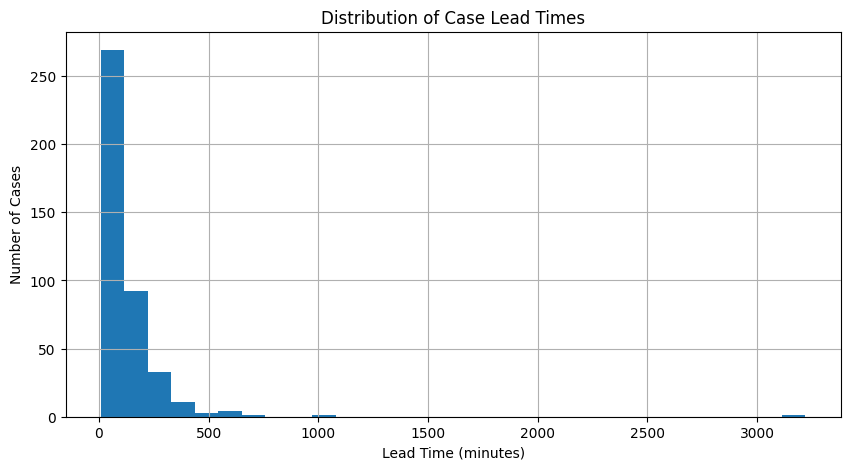

In [577]:
print("CALCULATING PERFORMANCE METRICS PER CASE")

# Group by case to calculate performance metrics
case_performance = df.groupby('case:concept:name').agg({
    'time:timestamp': ['min', 'max'],     # First and last event
    'processing_time': 'sum',             # Total processing time per case
    'lead_time': 'first'                  # Lead time (already calculated per case)
}).reset_index()

# Flatten column names
case_performance.columns = ['case:concept:name', 'start_time', 'end_time', 
                            'total_processing_time', 'lead_time']

print("Performance Metrics Summary:")
display(case_performance[['total_processing_time', 'lead_time']].describe().round(2))

print("\nSample cases:")
display(case_performance.head(10))

# Optional: Show distribution of lead times
print("\nLead Time Distribution:")
case_performance['lead_time'].hist(bins=30, figsize=(10, 5))
plt.xlabel('Lead Time (minutes)')
plt.ylabel('Number of Cases')
plt.title('Distribution of Case Lead Times')
plt.show()

### Step 5: Merge Datasets

In [578]:
print("MERGING ALL DATASETS")

# Add variant index to variant_df if not present
if 'variant_index' not in variant_df.columns:
    variant_df['variant_index'] = range(1, len(variant_df) + 1)

# Step 1: Merge df with case_variant_df (adds variant assignment to each case)
df_merged = df.merge(
    case_variant_df,
    left_on='case:concept:name',
    right_on='case_id',
    how='left'
)

# Step 2: Merge with variant_df (adds variant statistics)
df_merged = df_merged.merge(
    variant_df[['variant', 'frequency', 'percentage', 'variant_index']],
    on='variant',
    how='left'
)

# Step 3: Merge with case_performance (adds case-level performance metrics)
df_merged = df_merged.merge(
    case_performance[['case:concept:name', 'start_time', 'end_time', 
                      'total_processing_time', 'lead_time']],
    on='case:concept:name',
    how='left',
    suffixes=('', '_case')  # Avoid duplicate column names
)

# Display results
print(f"\nMerged Dataset Info:")
print(f"Total rows: {len(df_merged):,}")
print(f"Total columns: {len(df_merged.columns)}")

print(f"\nSample of Merged Dataset:")
display(df_merged.head(10))

print(f"\nAll columns in merged dataset:")
display(df_merged.columns.tolist())

# Optional: Check for any missing data after merge
print(f"\nMissing values check:")
display(df_merged.isnull().sum()[df_merged.isnull().sum() > 0])
display(df.isnull().sum()[df.isnull().sum() > 0])

MERGING ALL DATASETS

Merged Dataset Info:
Total rows: 2,632
Total columns: 32

Sample of Merged Dataset:


,Idade,Sexo,Nível de Urgência,CID,Médico Responsável,Doença,Data Inicial,time:timestamp,concept:name,Item,...,case_id,variant,variant_length,frequency,percentage,variant_index,start_time,end_time,total_processing_time,lead_time_case
0,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:22,2020-07-21 10:22:00,Atendimento,Atendimento,...,5446538,"(Atendimento, Triagem, Exames Laboratoriais, C...",5,2,0.451467,13,2020-07-21 10:22:00,2020-07-21 19:27:00,545.0,545.0
1,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 10:45,2020-07-21 10:49:00,Triagem,Triagem,...,5446538,"(Atendimento, Triagem, Exames Laboratoriais, C...",5,2,0.451467,13,2020-07-21 10:22:00,2020-07-21 19:27:00,545.0,545.0
2,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:01,2020-07-21 11:01:00,Exames Laboratoriais,Coronavírus COVID-19 - Diagnóstico Molecular (...,...,5446538,"(Atendimento, Triagem, Exames Laboratoriais, C...",5,2,0.451467,13,2020-07-21 10:22:00,2020-07-21 19:27:00,545.0,545.0
3,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 11:32,2020-07-21 11:32:00,Consulta,Consulta,...,5446538,"(Atendimento, Triagem, Exames Laboratoriais, C...",5,2,0.451467,13,2020-07-21 10:22:00,2020-07-21 19:27:00,545.0,545.0
4,31,F,Não informado,J111,Médico 72,J11.1 Influenza c/out manif resp dev virus n i...,21/07/2020 19:27,2020-07-21 19:27:00,Alta,Alta para completar tratamento,...,5446538,"(Atendimento, Triagem, Exames Laboratoriais, C...",5,2,0.451467,13,2020-07-21 10:22:00,2020-07-21 19:27:00,545.0,545.0
5,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:23,2020-07-21 10:23:00,Atendimento,Atendimento,...,5446540,"(Atendimento, Triagem, Consulta, Materiais Hos...",9,1,0.225734,29,2020-07-21 10:23:00,2020-07-21 19:26:00,543.0,543.0
6,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:25,2020-07-21 10:27:00,Triagem,Triagem,...,5446540,"(Atendimento, Triagem, Consulta, Materiais Hos...",9,1,0.225734,29,2020-07-21 10:23:00,2020-07-21 19:26:00,543.0,543.0
7,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:29,2020-07-21 10:29:00,Consulta,Consulta,...,5446540,"(Atendimento, Triagem, Consulta, Materiais Hos...",9,1,0.225734,29,2020-07-21 10:23:00,2020-07-21 19:26:00,543.0,543.0
8,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:37,2020-07-21 10:37:00,Materiais Hospitalares,Equipo Primeline Air IL (ref.401450p) (cx c/8...,...,5446540,"(Atendimento, Triagem, Consulta, Materiais Hos...",9,1,0.225734,29,2020-07-21 10:23:00,2020-07-21 19:26:00,543.0,543.0
9,74,F,Idoso,R073,Médico 72,R07.3 Outr dor toracica,21/07/2020 10:37,2020-07-21 10:37:00,Materiais Hospitalares,Cateter Perif. SAFETY 22G (cx c/200) ref. 425...,...,5446540,"(Atendimento, Triagem, Consulta, Materiais Hos...",9,1,0.225734,29,2020-07-21 10:23:00,2020-07-21 19:26:00,543.0,543.0



All columns in merged dataset:


['Idade',
 'Sexo',
 'Nível de Urgência',
 'CID',
 'Médico Responsável',
 'Doença',
 'Data Inicial',
 'time:timestamp',
 'concept:name',
 'Item',
 'Data Prescrição',
 'Tempo Processo',
 'Setor',
 'Quantidade',
 'Retorno',
 'Multipassante',
 'Convênio',
 'outlier_label',
 'case:concept:name',
 'processing_time',
 'incremental_processing_time',
 'lead_time',
 'case_id',
 'variant',
 'variant_length',
 'frequency',
 'percentage',
 'variant_index',
 'start_time',
 'end_time',
 'total_processing_time',
 'lead_time_case']


Missing values check:


Data Prescrição    2357
Tempo Processo     2357
Quantidade          125
Multipassante      2217
dtype: int64

Data Prescrição    2357
Tempo Processo     2357
Quantidade          125
Multipassante      2217
dtype: int64

### Step 6: Performance Measurements by Variant

In [579]:
# Calculate summary statistics for each variant
performance_cols = ['total_processing_time', 'lead_time_case']

variant_perf_summary = df_merged.groupby("variant_index")[performance_cols].agg(['mean', 'median', 'std', 'count']).reset_index()
variant_perf_summary.columns = ['_'.join(col).rstrip('_') for col in variant_perf_summary.columns.values]

print("Performance summary for variant #5:")
display(variant_perf_summary[variant_perf_summary['variant_index'] == 5])

print("\n \nVARIANT PERFORMANCE ANALYSIS")


# Top 5 fastest variants (by mean lead time) - ADD THIS LINE
fastest_variants = variant_perf_summary.nsmallest(5, 'lead_time_case_mean')
print("\nTop 5 FASTEST variants (lowest mean lead time):")
display(fastest_variants[['variant_index', 'lead_time_case_mean', 'lead_time_case_median', 
                          'total_processing_time_mean', 'lead_time_case_count']])

# Top 5 slowest variants (by mean lead time)
slowest_variants = variant_perf_summary.nlargest(5, 'lead_time_case_mean')
print("\nTop 5 SLOWEST variants (highest mean lead time):")
display(slowest_variants[['variant_index', 'lead_time_case_mean', 'lead_time_case_median', 
                          'total_processing_time_mean', 'lead_time_case_count']])

# Identify problematic variants (high lead time + sufficient case count for reliability)
problematic = variant_perf_summary.query(
    'lead_time_case_mean > 200 and lead_time_case_count >= 5'
).sort_values('lead_time_case_mean', ascending=False)
print(f"\nProblematic variants (mean lead time > 200 min, min 5 cases):")
display(problematic[['variant_index', 'lead_time_case_mean', 'lead_time_case_median', 
                     'lead_time_case_std', 'lead_time_case_count']].head(10))

# Summary statistics
print(f"\nOverall variant performance summary:")
print(f"Mean lead time across all variants: {variant_perf_summary['lead_time_case_mean'].mean():.2f} minutes")
print(f"Median lead time across all variants: {variant_perf_summary['lead_time_case_mean'].median():.2f} minutes")
print(f"Fastest variant mean: {variant_perf_summary['lead_time_case_mean'].min():.2f} minutes")
print(f"Slowest variant mean: {variant_perf_summary['lead_time_case_mean'].max():.2f} minutes")

Performance summary for variant #5:


,variant_index,total_processing_time_mean,total_processing_time_median,total_processing_time_std,total_processing_time_count,lead_time_case_mean,lead_time_case_median,lead_time_case_std,lead_time_case_count
4,5,170.5,168.5,66.23476,24,170.5,168.5,66.23476,24



 
VARIANT PERFORMANCE ANALYSIS

Top 5 FASTEST variants (lowest mean lead time):


,variant_index,lead_time_case_mean,lead_time_case_median,total_processing_time_mean,lead_time_case_count
8,11,35.5,35.5,35.5,8
74,93,38.0,38.0,38.0,5
64,82,50.0,50.0,50.0,7
39,49,55.0,55.0,55.0,11
0,1,78.0,57.0,78.0,988



Top 5 SLOWEST variants (highest mean lead time):


,variant_index,lead_time_case_mean,lead_time_case_median,total_processing_time_mean,lead_time_case_count
13,17,1682.0,1682.0,1682.0,24
20,27,1051.0,1051.0,1051.0,16
63,80,698.0,698.0,698.0,7
27,35,622.0,622.0,622.0,16
28,37,576.0,576.0,576.0,22



Problematic variants (mean lead time > 200 min, min 5 cases):


,variant_index,lead_time_case_mean,lead_time_case_median,lead_time_case_std,lead_time_case_count
13,17,1682.0,1682.0,1572.100561,24
20,27,1051.0,1051.0,0.000000,16
63,80,698.0,698.0,0.000000,7
27,35,622.0,622.0,0.000000,16
28,37,576.0,576.0,0.000000,22
67,85,560.0,560.0,0.000000,13
22,29,543.0,543.0,0.000000,9
54,68,465.0,465.0,0.000000,26
42,52,445.0,445.0,0.000000,12
75,95,428.0,428.0,0.000000,26



Overall variant performance summary:
Mean lead time across all variants: 230.19 minutes
Median lead time across all variants: 172.25 minutes
Fastest variant mean: 35.50 minutes
Slowest variant mean: 1682.00 minutes


In [580]:
# CORRECTED ANALYSIS: Case-Level Variance Calculation

# Get unique case-level data for proper std calculation
case_level_data = df_merged.drop_duplicates(subset=['case:concept:name'])[
    ['case:concept:name', 'variant_index', 'total_processing_time', 'lead_time_case']
]

# Recalculate variant performance with proper case-level aggregation
variant_perf_summary_corrected = case_level_data.groupby("variant_index").agg({
    'total_processing_time': ['mean', 'median', 'std', 'count'],
    'lead_time_case': ['mean', 'median', 'std']
}).reset_index()

variant_perf_summary_corrected.columns = ['_'.join(col).rstrip('_') for col in variant_perf_summary_corrected.columns.values]

print("\nCorrected problematic variants (with proper std calculation):")
problematic_corrected = variant_perf_summary_corrected.query(
    'lead_time_case_mean > 200 and total_processing_time_count >= 5'
).sort_values('lead_time_case_mean', ascending=False)

display(problematic_corrected[['variant_index', 'lead_time_case_mean', 'lead_time_case_median', 
                                'lead_time_case_std', 'total_processing_time_count']].head(10))

# Verify: Check a specific variant's actual case lead times
print("\nVerification - Variant 17 individual case lead times:")
variant_17_cases = case_level_data[case_level_data['variant_index'] == 17]['lead_time_case']
display(variant_17_cases.describe())


Corrected problematic variants (with proper std calculation):


,variant_index,lead_time_case_mean,lead_time_case_median,lead_time_case_std,total_processing_time_count
3,4,221.625,201.0,84.286819,8



Verification - Variant 17 individual case lead times:


count       2.000000
mean     1682.000000
std      2176.474672
min       143.000000
25%       912.500000
50%      1682.000000
75%      2451.500000
max      3221.000000
Name: lead_time_case, dtype: float64

### Step 7: Variants with Performance Visualization

##### plot 1: Variant Performance Analysis: Frequency vs Lead Time

VARIANT PERFORMANCE VISUALIZATIONS

1. MEDIAN LEAD TIME - Top 10 Most Frequent Variants
Analyzing top 10 most frequent variants: [1, 2, 3, 4, 5, 6, 8, 10, 11, 13]


/tmp/ipykernel_3795/3259057108.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='variant_index', y=metric, palette='viridis')


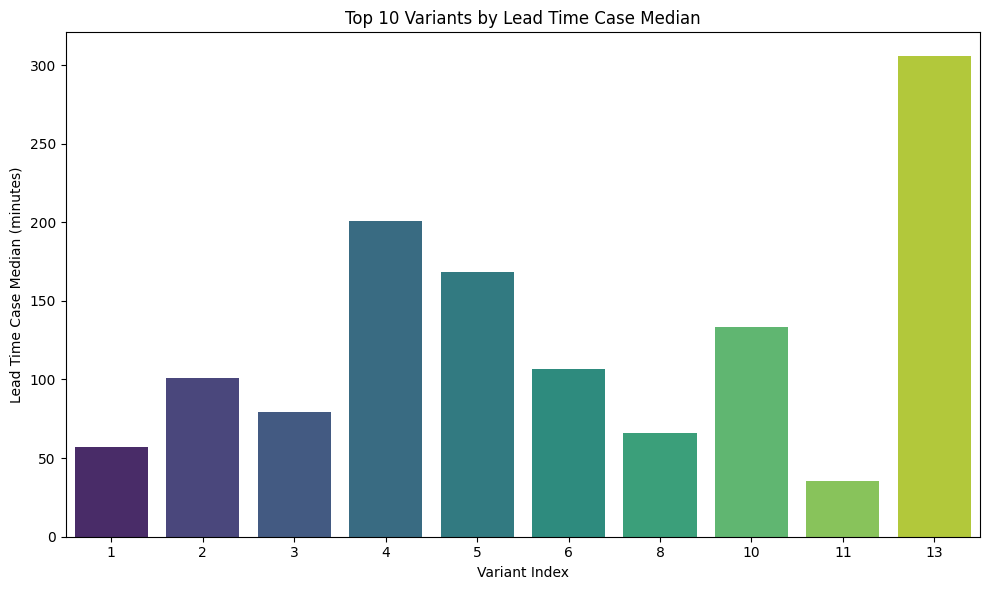


2. MEAN LEAD TIME (Log Scale) - Top 10 Most Frequent Variants
Analyzing top 10 most frequent variants: [1, 2, 3, 4, 5, 6, 8, 10, 11, 13]


/tmp/ipykernel_3795/3259057108.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='variant_index', y=metric, palette='viridis')


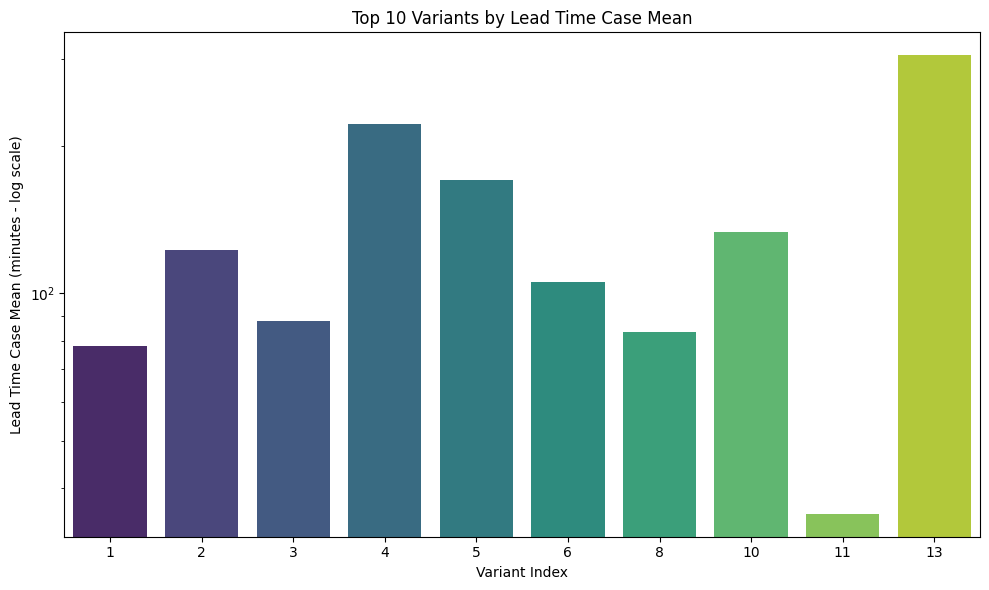


FREQUENCY vs PERFORMANCE ANALYSIS

Top 10 FREQUENT variants and their performance:


,variant_index,frequency,lead_time_case_mean,lead_time_case_median,lead_time_case_std
0,1,247,78.000000,57.0,71.627597
1,2,49,122.510204,101.0,73.566665
2,3,12,87.916667,79.5,53.813013
3,4,8,221.625000,201.0,79.556626
4,5,4,170.500000,168.5,66.234760
5,6,4,105.250000,106.5,9.502631
6,8,3,83.333333,66.0,36.900768
7,10,2,133.500000,133.5,20.876178
8,11,2,35.500000,35.5,8.017837
9,13,2,305.500000,305.5,252.455167



KEY INSIGHTS
Most frequent variant: 1.0 (247.0 cases)
  - Mean lead time: 78.00 minutes
  - Median lead time: 57.00 minutes

No high-frequency slow variants found (good performance overall!)


In [581]:
print("VARIANT PERFORMANCE VISUALIZATIONS")


# Visualize mean/median performance metric per variant
def plot_variant_performance(metric='lead_time_case_median', top_n=10, log_scale=False):
    """
    Visualize mean/median performance metric per variant.
    """
    if metric not in variant_perf_summary.columns:
        raise ValueError(f"{metric} not found. Available: {list(variant_perf_summary.columns)}")
    
    # Select top-k variant indices by frequency
    top_variants = (
        case_level_data.groupby('variant_index')
        .size()
        .sort_values(ascending=False)
        .head(top_n)
        .index
        .tolist()
    )

    print(f"Analyzing top {top_n} most frequent variants: {top_variants}")
    
    df_plot = variant_perf_summary.query('variant_index in @top_variants').sort_values(metric, ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='variant_index', y=metric, palette='viridis')
    plt.title(f"Top {top_n} Variants by {metric.replace('_', ' ').title()}")
    plt.xlabel("Variant Index")
    plt.ylabel(f"{metric.replace('_', ' ').title()} (minutes)")
    
    # Use log scale if requested
    if log_scale:
        plt.yscale('log')
        plt.ylabel(f"{metric.replace('_', ' ').title()} (minutes - log scale)")
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Visualization 1: Median lead time for top 10 most frequent variants
print("\n1. MEDIAN LEAD TIME - Top 10 Most Frequent Variants")
plot_variant_performance(metric='lead_time_case_median', top_n=10, log_scale=False)

# Visualization 2: Mean lead time with log scale (to see variation)
print("\n2. MEAN LEAD TIME (Log Scale) - Top 10 Most Frequent Variants")
plot_variant_performance(metric='lead_time_case_mean', top_n=10, log_scale=True)

# Combine frequency and performance analysis
print("\n" + "="*80)
print("FREQUENCY vs PERFORMANCE ANALYSIS")

frequency_counts = case_level_data.groupby('variant_index').size().reset_index(name='frequency')
combined = variant_perf_summary.merge(frequency_counts, on='variant_index')
combined = combined.sort_values('frequency', ascending=False)

print("\nTop 10 FREQUENT variants and their performance:")
display(combined.head(10)[['variant_index', 'frequency', 'lead_time_case_mean', 
                           'lead_time_case_median', 'lead_time_case_std']])

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print(f"Most frequent variant: {combined.iloc[0]['variant_index']} ({combined.iloc[0]['frequency']} cases)")
print(f"  - Mean lead time: {combined.iloc[0]['lead_time_case_mean']:.2f} minutes")
print(f"  - Median lead time: {combined.iloc[0]['lead_time_case_median']:.2f} minutes")

high_freq_slow = combined.query('frequency > 10 and lead_time_case_mean > 200')
if len(high_freq_slow) > 0:
    print(f"\nHigh-frequency slow variants (>10 cases, >200 min):")
    for idx, row in high_freq_slow.iterrows():
        print(f"  Variant #{int(row['variant_index'])}: {int(row['frequency'])} cases, {row['lead_time_case_mean']:.0f} min avg")
else:
    print("\nNo high-frequency slow variants found (good performance overall!)")

##### plot 2: Distribution Analysis: Performance Metric Variability by Variant

DISTRIBUTION ANALYSIS - VIOLIN PLOTS

1. PROCESSING TIME Distribution - Top 10 Variants
Analyzing distribution for top 10 variants: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/tmp/ipykernel_3795/1250838019.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_3795/1250838019.py:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


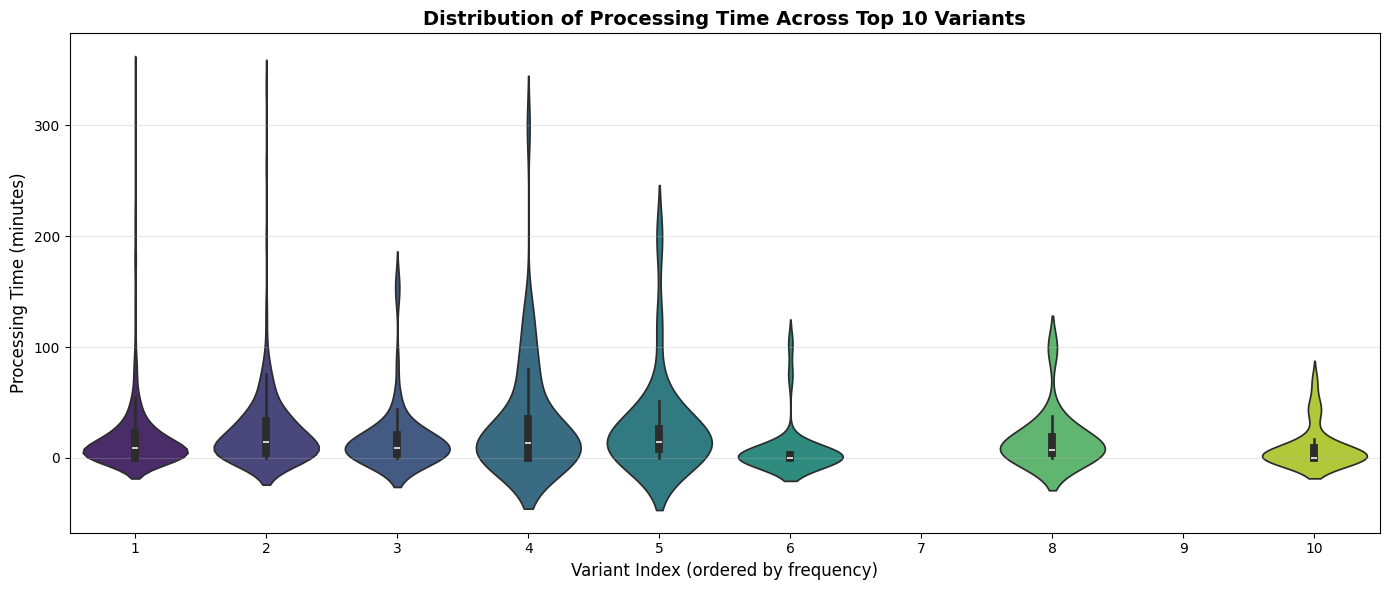


2. LEAD TIME Distribution - Top 10 Variants
Analyzing distribution for top 10 variants: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/tmp/ipykernel_3795/1250838019.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_3795/1250838019.py:31: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


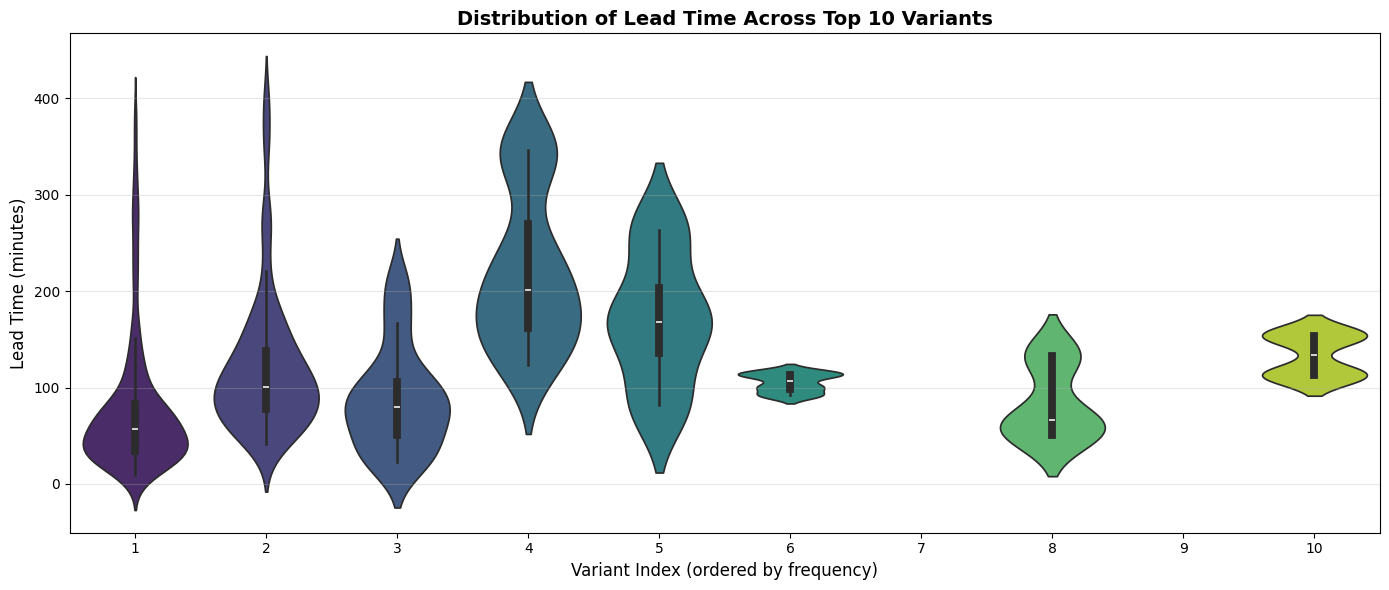

In [582]:
print("DISTRIBUTION ANALYSIS - VIOLIN PLOTS")

def plot_variant_violin(
    metric='processing_time', 
    top_k=10,                 
    log_scale=False      
):

    # Identify top-k variants by percentage/frequency
    top_variant_indices = (
        variant_df
        .sort_values('percentage', ascending=False)
        .head(top_k)['variant_index']
        .tolist()
    )

    print(f"Analyzing distribution for top {top_k} variants: {top_variant_indices}")

    # Filter df_merged for those variants
    df_plot = df_merged[df_merged['variant_index'].isin(top_variant_indices)].copy()

    # Sort variant_index by frequency for better display
    df_plot['variant_index'] = pd.Categorical(
        df_plot['variant_index'],
        categories=top_variant_indices,
        ordered=True
    )

    # Create the violin plot
    plt.figure(figsize=(14, 6))
    sns.violinplot(
        data=df_plot,
        x='variant_index',
        y=metric,
        inner='box',
        scale='width',
        palette='viridis'
    )

    plt.title(f"Distribution of {metric.replace('_', ' ').title()} Across Top {top_k} Variants", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Variant Index (ordered by frequency)", fontsize=12)
    plt.ylabel(f"{metric.replace('_', ' ').title()} (minutes)", fontsize=12)
    
    if log_scale:
        plt.yscale('log')
        plt.ylabel(f"{metric.replace('_', ' ').title()} (minutes - log scale)", fontsize=12)
    
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualization 1: Processing time distribution
print("\n1. PROCESSING TIME Distribution - Top 10 Variants")
plot_variant_violin(metric='processing_time', top_k=10, log_scale=False)

# Visualization 2: Lead time distribution (event-level)
print("\n2. LEAD TIME Distribution - Top 10 Variants")
plot_variant_violin(metric='lead_time', top_k=10, log_scale=False)

##### plot 3: Variant Frequency Distribution: Power-Law & Pareto Analysis

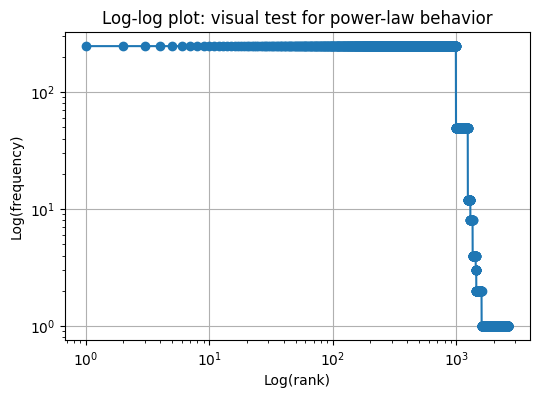

Calculating best minimal value for power law fit
Estimated alpha: 1.302
Estimated xmin: 1.0
R vs lognormal: -123.406, p-value: 0.000


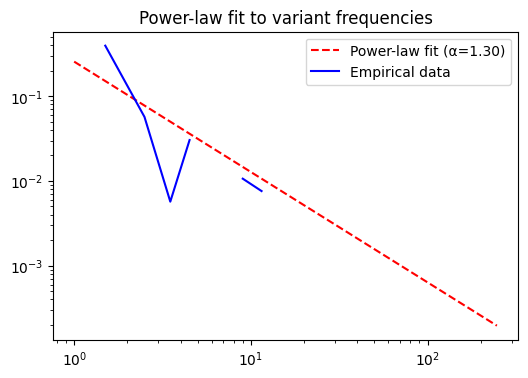

In [583]:


# --- Assume df already exists with columns 'variant' and 'frequency' ---
freqs = df_merged['frequency'].sort_values(ascending=False).values

# --- Log-log plot to visually test Pareto behavior ---
plt.figure(figsize=(6,4))
plt.loglog(range(1, len(freqs)+1), freqs, marker='o', linestyle='solid')
plt.xlabel('Log(rank)')
plt.ylabel('Log(frequency)')
plt.title('Log-log plot: visual test for power-law behavior')
plt.grid(True)
plt.show()

# --- Fit Pareto/power-law using the 'powerlaw' package ---
fit = powerlaw.Fit(freqs, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

# Compare to alternative distributions
R, p = fit.distribution_compare('power_law', 'lognormal')

print(f"Estimated alpha: {alpha:.3f}")
print(f"Estimated xmin: {xmin}")
print(f"R vs lognormal: {R:.3f}, p-value: {p:.3f}")

# --- Plot fit for comparison ---
plt.figure(figsize=(6,4))
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power-law fit (α={alpha:.2f})')
fit.plot_pdf(color='b', label='Empirical data')
plt.legend()
plt.title('Power-law fit to variant frequencies')
plt.show()

# SEGMENTS OF TEH LOG

### Step 1: Clinical Segmentation Analysis


In [584]:
# STEP 1: IDENTIFYING AVAILABLE CLINICAL ATTRIBUTES

# Your available clinical attributes I have to use the merged_df
clinical_attributes = {
    'Nível de Urgência': 'Urgency Level (Triage Classification)',
    'Setor': 'Department/Sector',
    'Doença': 'Disease/Diagnosis',
    'Convênio': 'Insurance/Health Plan Type',
    'Sexo': 'Gender',
    'Idade': 'Age',
    'Retorno': 'Return Visit (Yes/No)',
    'Multipassante': 'Repeat Patient'
}

print("\nAvailable clinical attributes for segmentation:")
print("-" * 80)

for col, description in clinical_attributes.items():
    if col in df_merged.columns:
        print(f"\n {col} ({description})")
        print(f"  Unique values: {df_merged[col].nunique()}")
        
        # Show sample values (limit to 10)
        unique_vals = df_merged[col].dropna().unique()
        if len(unique_vals) <= 10:
            print(f"  Values: {unique_vals.tolist()}")
        else:
            print(f"  Sample values: {unique_vals[:10].tolist()}")
        
        # Count non-null values
        non_null = df_merged[col].notna().sum()
        total = len(df_merged)
        print(f"  Non-null: {non_null:,} ({non_null/total*100:.1f}%)")
        print(f"  Missing: {total - non_null:,} ({(total - non_null)/total*100:.1f}%)")



Available clinical attributes for segmentation:
--------------------------------------------------------------------------------

 Nível de Urgência (Urgency Level (Triage Classification))
  Unique values: 9
  Values: ['Não informado', 'Idoso', 'Baixo', 'Média', 'Dor Torácica', 'Gestante', 'Portador de deficiência', 'Coletar PCR', 'Sem prioridade - Azul']
  Non-null: 2,632 (100.0%)
  Missing: 0 (0.0%)

 Setor (Department/Sector)
  Unique values: 1
  Values: ['Setor Pronto Atendimento']
  Non-null: 2,632 (100.0%)
  Missing: 0 (0.0%)

 Doença (Disease/Diagnosis)
  Unique values: 7
  Values: ['J11.1 Influenza c/out manif resp dev virus n ident', 'R07.3 Outr dor toracica', 'R07.4 Dor toracica NE', 'N23   Colica nefretica NE', 'J12.9 Pneumonia viral NE', 'I64   Acid vasc cerebr NE como hemorrag isquemico', 'J10.1 Influenz c/out manif resp dev vir infl ident']
  Non-null: 2,632 (100.0%)
  Missing: 0 (0.0%)

 Convênio (Insurance/Health Plan Type)
  Unique values: 10
  Values: ['Convênio 9', 

### Step 2: Segmentation Setup

✓ Segmenting by: Nível de Urgência

Data preparation:
  Original cases: 415
  Cases with valid Nível de Urgência: 415
  Removed (missing attribute): 0 (0.0%)

Segment Distribution:
Number of segments: 9

Cases per segment:
  Baixo: 
     265 cases (63.9%)
  Não informado: 
     60 cases (14.5%)
  Média: 
     35 cases (8.4%)
  Idoso: 
     30 cases (7.2%)
  Coletar PCR: 
     11 cases (2.7%)
  Dor Torácica: 
     5 cases (1.2%)
  Gestante: 
     5 cases (1.2%)
  Portador de deficiência: 
     3 cases (0.7%)
  Sem prioridade - Azul: 
     1 cases (0.2%)


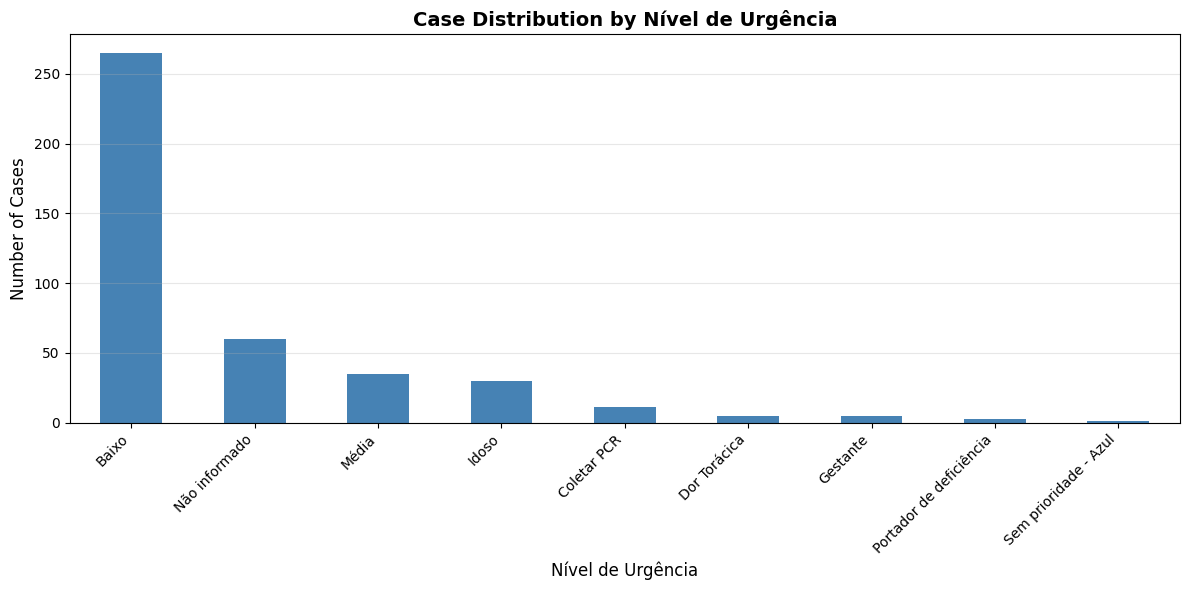


 Segments with ≥10 cases: 5
Valid segments: ['Baixo', 'Não informado', 'Média', 'Idoso', 'Coletar PCR']

Cases retained for analysis: 401 (96.6%)


In [585]:
# STEP 2: SELECTING SEGMENTATION ATTRIBUTE

#  Use 'Nível de Urgência' (Urgency Level) for ER analysis
SEGMENTATION_ATTRIBUTE = 'Nível de Urgência'  

print(f"✓ Segmenting by: {SEGMENTATION_ATTRIBUTE}")

# Get case-level data (one row per case)
case_data = df_merged.drop_duplicates(subset=['case:concept:name'])[[
    'case:concept:name', SEGMENTATION_ATTRIBUTE, 'variant_index', 
    'total_processing_time', 'lead_time_case'
]].copy()

# Remove cases with missing segmentation attribute
original_count = len(case_data)
case_data = case_data.dropna(subset=[SEGMENTATION_ATTRIBUTE])
removed = original_count - len(case_data)

print(f"\nData preparation:")
print(f"  Original cases: {original_count:,}")
print(f"  Cases with valid {SEGMENTATION_ATTRIBUTE}: {len(case_data):,}")
print(f"  Removed (missing attribute): {removed:,} ({removed/original_count*100:.1f}%)")

# Analyze segment distribution
segment_counts = case_data[SEGMENTATION_ATTRIBUTE].value_counts().sort_values(ascending=False)
segment_percentages = (segment_counts / segment_counts.sum() * 100).round(1)

print(f"\nSegment Distribution:")
print(f"Number of segments: {len(segment_counts)}")
print(f"\nCases per segment:")

for segment, count in segment_counts.items():
    pct = segment_percentages[segment]
    print(f"  {segment}: \n     {count} cases ({pct}%)")

# Visualize segment distribution
plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar', color='steelblue')
plt.title(f'Case Distribution by {SEGMENTATION_ATTRIBUTE}', fontsize=14, fontweight='bold')
plt.xlabel(SEGMENTATION_ATTRIBUTE, fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Filter to segments with sufficient cases for reliable analysis
MIN_CASES = 10
valid_segments = segment_counts[segment_counts >= MIN_CASES].index.tolist()

print(f"\n Segments with ≥{MIN_CASES} cases: {len(valid_segments)}")
if len(valid_segments) > 0:
    print(f"Valid segments: {valid_segments}")
    
    # Filter data to valid segments only
    case_data_filtered = case_data[case_data[SEGMENTATION_ATTRIBUTE].isin(valid_segments)]
    print(f"\nCases retained for analysis: {len(case_data_filtered):,} ({len(case_data_filtered)/len(case_data)*100:.1f}%)")
else:
    print("⚠️ No segments have enough cases. Consider lowering MIN_CASES or choosing different attribute.")

### Step 3: Comparative Variant Analysis


Top 5 variants for each segment:

Nível de Urgência = 'Baixo':
  Variant 1: 177 cases (66.8%)
  Variant 2: 33 cases (12.5%)
  Variant 3: 7 cases (2.6%)
  Variant 5: 4 cases (1.5%)
  Variant 4: 3 cases (1.1%)

Nível de Urgência = 'Não informado':
  Variant 1: 44 cases (73.3%)
  Variant 2: 6 cases (10.0%)
  Variant 4: 1 cases (1.7%)
  Variant 8: 1 cases (1.7%)
  Variant 13: 1 cases (1.7%)

Nível de Urgência = 'Média':
  Variant 1: 5 cases (14.3%)
  Variant 6: 3 cases (8.6%)
  Variant 2: 2 cases (5.7%)
  Variant 15: 2 cases (5.7%)
  Variant 4: 1 cases (2.9%)

Nível de Urgência = 'Idoso':
  Variant 1: 10 cases (33.3%)
  Variant 2: 7 cases (23.3%)
  Variant 4: 3 cases (10.0%)
  Variant 6: 1 cases (3.3%)
  Variant 14: 1 cases (3.3%)

Nível de Urgência = 'Coletar PCR':
  Variant 1: 6 cases (54.5%)
  Variant 3: 4 cases (36.4%)
  Variant 100: 1 cases (9.1%)

  Visualizing variant distribution across segments...


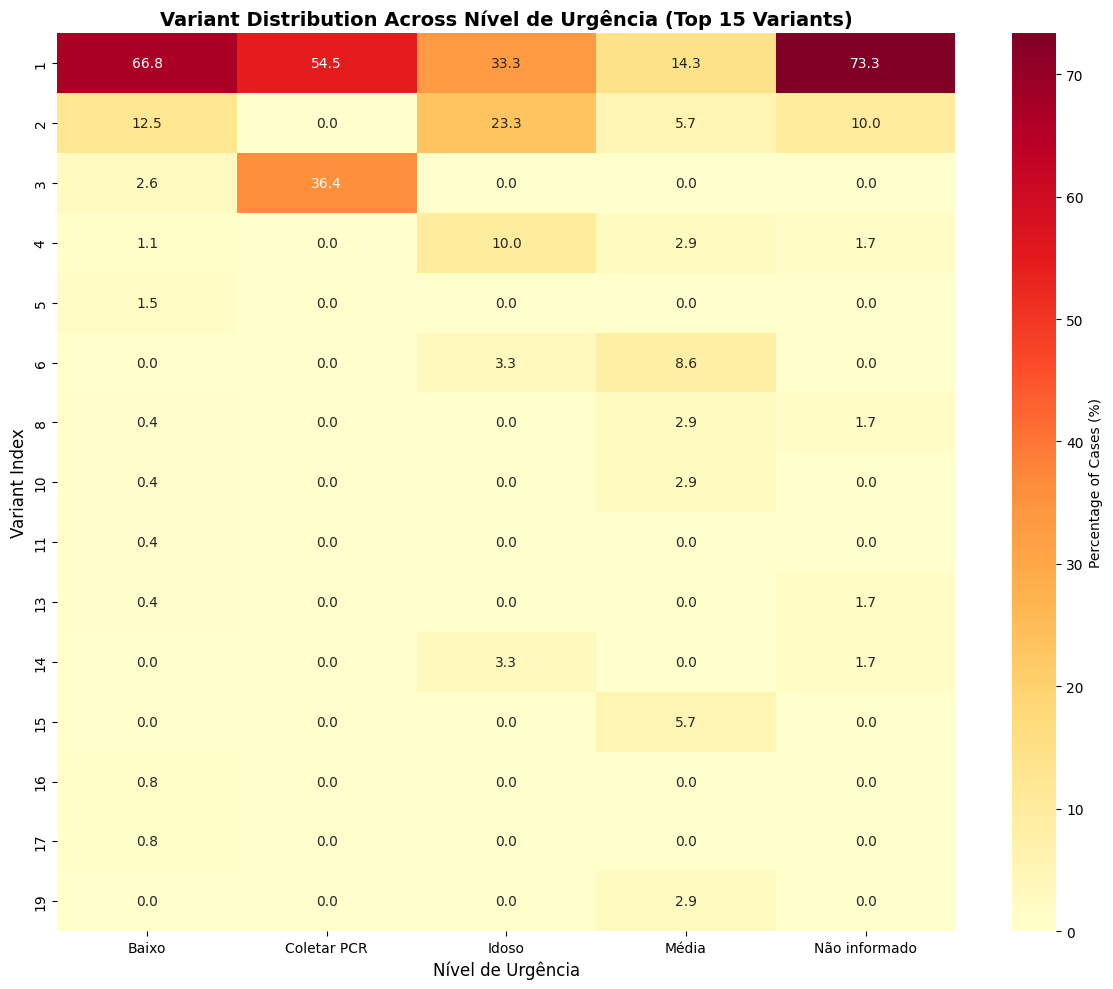


 
CHI-SQUARE TEST: Variant Independence
Null hypothesis: Variant distribution is independent of Nível de Urgência
Chi-square statistic: 208.37
p-value: 0.0000
Degrees of freedom: 56

 SIGNIFICANT (p < 0.05): Variant distribution DIFFERS across Nível de Urgência
 Different urgency levels follow different process paths


In [586]:
# STEP 3: VARIANT ANALYSIS BY SEGMENT
      

# Calculate variant distribution per segment
variant_by_segment = (
    case_data_filtered.groupby([SEGMENTATION_ATTRIBUTE, 'variant_index'])
    .size()
    .reset_index(name='count')
)

# Calculate percentage within each segment
variant_by_segment['percentage'] = (
    variant_by_segment.groupby(SEGMENTATION_ATTRIBUTE)['count']
    .transform(lambda x: x / x.sum() * 100)
)

# Top 5 variants per segment
print("\nTop 5 variants for each segment:")
for segment in valid_segments:
    print(f"\n{SEGMENTATION_ATTRIBUTE} = '{segment}':")
    segment_data = variant_by_segment[variant_by_segment[SEGMENTATION_ATTRIBUTE] == segment]
    top_variants = segment_data.nlargest(5, 'percentage')
    for _, row in top_variants.iterrows():
        print(f"  Variant {int(row['variant_index'])}: {row['count']} cases ({row['percentage']:.1f}%)")

# Visualization: Top variants by segment (heatmap)
print("\n  Visualizing variant distribution across segments...")

# Get top 15 variants overall
top_variants_list = (
    variant_by_segment.groupby('variant_index')['count']
    .sum()
    .nlargest(15)
    .index.tolist()
)

# Create heatmap data
heatmap_data = variant_by_segment[
    (variant_by_segment['variant_index'].isin(top_variants_list)) &
    (variant_by_segment[SEGMENTATION_ATTRIBUTE].isin(valid_segments))
].pivot(index='variant_index', columns=SEGMENTATION_ATTRIBUTE, values='percentage').fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage of Cases (%)'})
plt.title(f'Variant Distribution Across {SEGMENTATION_ATTRIBUTE} (Top 15 Variants)', 
          fontsize=14, fontweight='bold')
plt.xlabel(SEGMENTATION_ATTRIBUTE, fontsize=12)
plt.ylabel('Variant Index', fontsize=12)
plt.tight_layout()
plt.show()

# Statistical test: Are variant distributions different across segments?

if len(valid_segments) >= 2 and len(top_variants_list) >= 2:
    # Create contingency table
    contingency_data = variant_by_segment[
        (variant_by_segment['variant_index'].isin(top_variants_list)) &
        (variant_by_segment[SEGMENTATION_ATTRIBUTE].isin(valid_segments))
    ].pivot_table(index='variant_index', columns=SEGMENTATION_ATTRIBUTE, 
                  values='count', fill_value=0)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_data)
    

    print("\n \nCHI-SQUARE TEST: Variant Independence")
    print(f"Null hypothesis: Variant distribution is independent of {SEGMENTATION_ATTRIBUTE}")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print(f"\n SIGNIFICANT (p < 0.05): Variant distribution DIFFERS across {SEGMENTATION_ATTRIBUTE}")
        print(f" Different urgency levels follow different process paths")
    else:
        print(f"\n NOT SIGNIFICANT (p ≥ 0.05): Variant distribution is similar across {SEGMENTATION_ATTRIBUTE}")
        print(f"All urgency levels follow similar process paths")
else:
    print("\n Not enough segments or variants for chi-square test")

### Step 4: Performance Comparison by Urgency Level


Performance metrics by Nível de Urgência:


,lead_time_case_mean,lead_time_case_median,lead_time_case_std,lead_time_case_min,lead_time_case_max,total_processing_time_mean,total_processing_time_median,num_cases
Nível de Urgência,,,,,,,,
Média,174.51,160.0,110.95,16.0,560.0,174.51,160.0,35
Idoso,146.27,123.0,111.02,25.0,543.0,146.27,123.0,30
Baixo,118.29,78.0,216.79,11.0,3221.0,118.29,78.0,265
Não informado,114.67,49.0,139.46,9.0,698.0,114.67,49.0,60
Coletar PCR,61.64,47.0,41.10,21.0,142.0,61.64,47.0,11


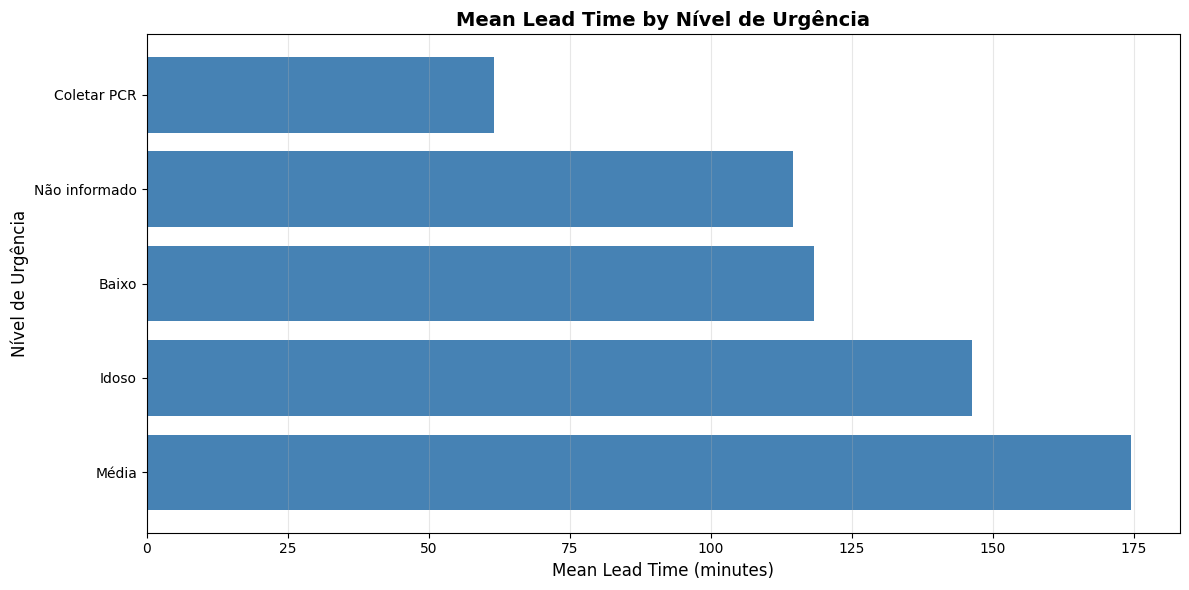


 Lead time distribution across segments:


/tmp/ipykernel_3795/1070654367.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=case_data_filtered, x=SEGMENTATION_ATTRIBUTE, y='lead_time_case', palette='Set2')


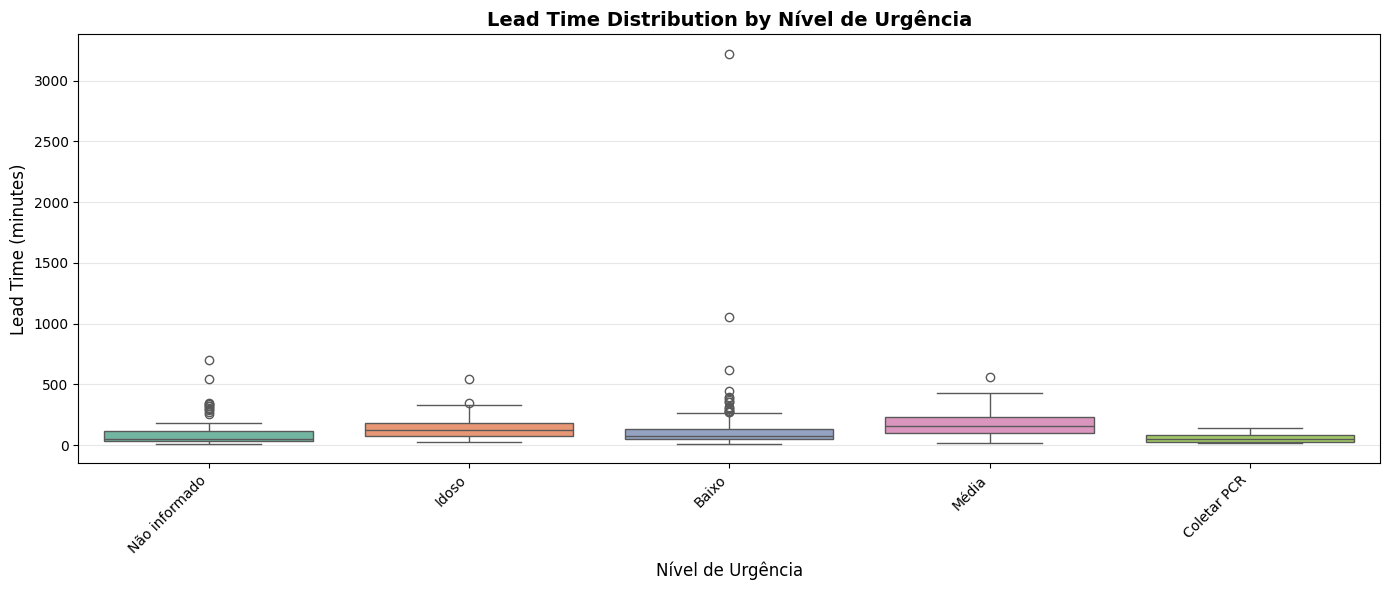

ANOVA TEST: Lead Time Comparison
Null hypothesis: Mean lead time is equal across all Nível de Urgência groups
F-statistic: 1.11
p-value: 0.3523

NOT SIGNIFICANT (p ≥ 0.05): Lead times are similar across Nível de Urgência
All urgency levels have comparable lead times


In [587]:
# STEP 4: PERFORMANCE METRICS BY SEGMENT

# Calculate performance statistics per segment
performance_by_segment = case_data_filtered.groupby(SEGMENTATION_ATTRIBUTE).agg({
    'lead_time_case': ['mean', 'median', 'std', 'min', 'max'],
    'total_processing_time': ['mean', 'median'],
    'case:concept:name': 'count'
}).round(2)

performance_by_segment.columns = ['_'.join(col).strip() for col in performance_by_segment.columns.values]
performance_by_segment = performance_by_segment.rename(columns={'case:concept:name_count': 'num_cases'})
performance_by_segment = performance_by_segment.sort_values('lead_time_case_mean', ascending=False)

print(f"\nPerformance metrics by {SEGMENTATION_ATTRIBUTE}:")
display(performance_by_segment)

# Visualization 1: Mean lead time comparison
plt.figure(figsize=(12, 6))
segments_sorted = performance_by_segment.sort_values('lead_time_case_mean', ascending=False).index
data_plot = performance_by_segment.loc[segments_sorted]

plt.barh(range(len(data_plot)), data_plot['lead_time_case_mean'], color='steelblue')
plt.yticks(range(len(data_plot)), segments_sorted)
plt.xlabel('Mean Lead Time (minutes)', fontsize=12)
plt.ylabel(SEGMENTATION_ATTRIBUTE, fontsize=12)
plt.title(f'Mean Lead Time by {SEGMENTATION_ATTRIBUTE}', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Box plots for distribution comparison
print("\n Lead time distribution across segments:")

plt.figure(figsize=(14, 6))
sns.boxplot(data=case_data_filtered, x=SEGMENTATION_ATTRIBUTE, y='lead_time_case', palette='Set2')
plt.xlabel(SEGMENTATION_ATTRIBUTE, fontsize=12)
plt.ylabel('Lead Time (minutes)', fontsize=12)
plt.title(f'Lead Time Distribution by {SEGMENTATION_ATTRIBUTE}', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical test: ANOVA (Are means significantly different?)
if len(valid_segments) >= 2:
    
    print("ANOVA TEST: Lead Time Comparison")
    
    # Prepare data for ANOVA
    groups = []
    for segment in valid_segments:
        segment_lead_times = case_data_filtered[
            case_data_filtered[SEGMENTATION_ATTRIBUTE] == segment
        ]['lead_time_case'].dropna().values
        groups.append(segment_lead_times)
    
    f_stat, p_value_anova = f_oneway(*groups)
    
    print(f"Null hypothesis: Mean lead time is equal across all {SEGMENTATION_ATTRIBUTE} groups")
    print(f"F-statistic: {f_stat:.2f}")
    print(f"p-value: {p_value_anova:.4f}")
    
    if p_value_anova < 0.05:
        print(f"\nSIGNIFICANT (p < 0.05): Lead times DIFFER significantly across {SEGMENTATION_ATTRIBUTE}")
        print(f"Some urgency levels experience significantly longer/shorter lead times")
    else:
        print(f"\nNOT SIGNIFICANT (p ≥ 0.05): Lead times are similar across {SEGMENTATION_ATTRIBUTE}")
        print(f"All urgency levels have comparable lead times")
    
    # Pairwise comparison (if significant and manageable number of groups)
    if p_value_anova < 0.05 and len(valid_segments) <= 6:
        from scipy.stats import ttest_ind
        
        print("PAIRWISE T-TESTS (Bonferroni corrected):")
        
        n_comparisons = len(valid_segments) * (len(valid_segments) - 1) / 2
        alpha_corrected = 0.05 / n_comparisons
        
        print(f"Number of comparisons: {int(n_comparisons)}")
        print(f"Corrected significance level: {alpha_corrected:.4f}\n")
        
        for i in range(len(valid_segments)):
            for j in range(i+1, len(valid_segments)):
                seg1, seg2 = valid_segments[i], valid_segments[j]
                data1 = case_data_filtered[case_data_filtered[SEGMENTATION_ATTRIBUTE] == seg1]['lead_time_case']
                data2 = case_data_filtered[case_data_filtered[SEGMENTATION_ATTRIBUTE] == seg2]['lead_time_case']
                
                t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
                
                if p_val < alpha_corrected:
                    diff = data1.mean() - data2.mean()
                    print(f"  '{seg1}' vs '{seg2}': p={p_val:.4f} ✓ SIGNIFICANT (diff={diff:.1f} min)")
else:
    print("\n Not enough segments for statistical testing")

### Step 5: Activity Pattern Analysis by Urgency Level


Analyzing 2,505 events across 5 segments

Top 5 activities for each segment:

Nível de Urgência = 'Baixo':
  Alta: 265 occurrences (18.4%)
  Atendimento: 265 occurrences (18.4%)
  Consulta: 265 occurrences (18.4%)
  Triagem: 265 occurrences (18.4%)
  Medicamentos: 136 occurrences (9.5%)

Nível de Urgência = 'Não informado':
  Alta: 60 occurrences (18.9%)
  Atendimento: 60 occurrences (18.9%)
  Consulta: 60 occurrences (18.9%)
  Triagem: 60 occurrences (18.9%)
  Medicamentos: 29 occurrences (9.1%)

Nível de Urgência = 'Média':
  Medicamentos: 151 occurrences (33.2%)
  Materiais Hospitalares: 116 occurrences (25.5%)
  Alta: 35 occurrences (7.7%)
  Atendimento: 35 occurrences (7.7%)
  Consulta: 35 occurrences (7.7%)

Nível de Urgência = 'Idoso':
  Exames Laboratoriais: 36 occurrences (14.9%)
  Materiais Hospitalares: 36 occurrences (14.9%)
  Medicamentos: 32 occurrences (13.3%)
  Alta: 30 occurrences (12.4%)
  Atendimento: 30 occurrences (12.4%)

Nível de Urgência = 'Coletar PCR':
  Alta:

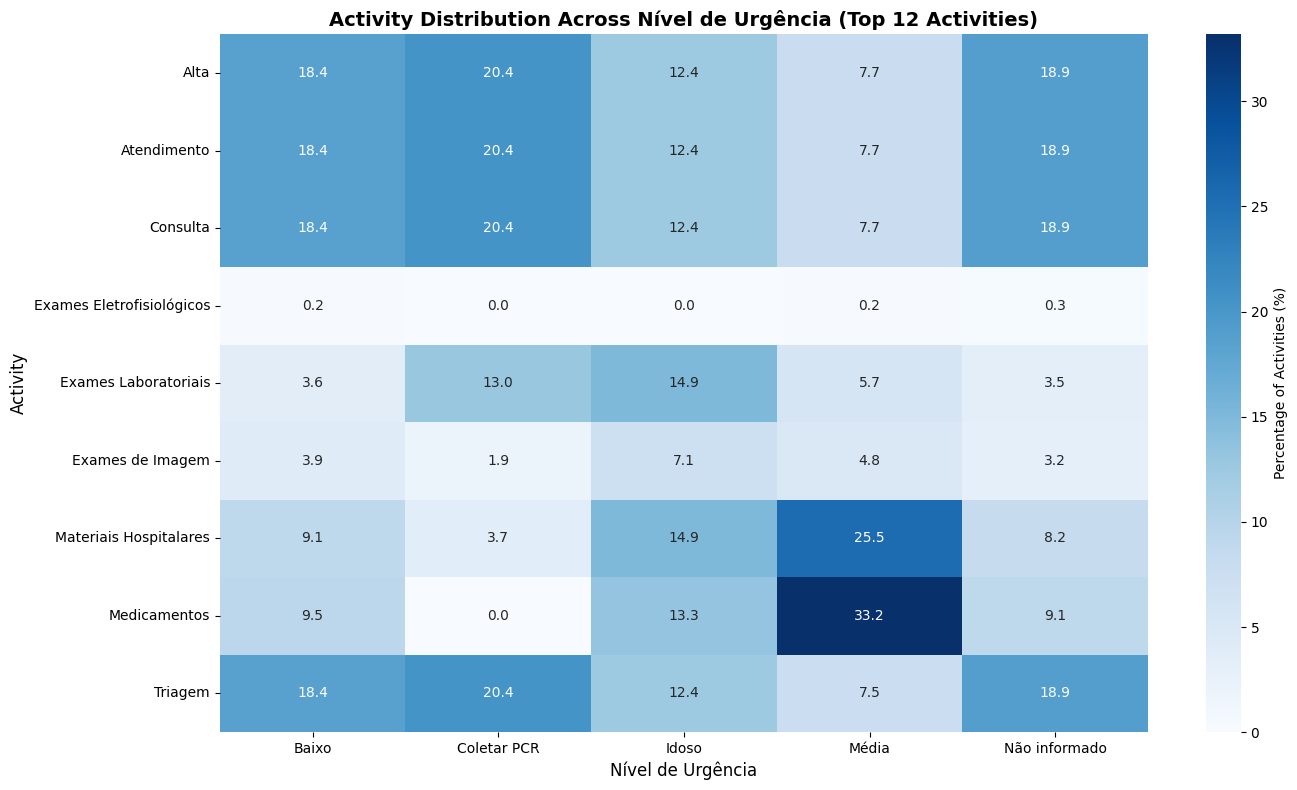

In [588]:
# STEP 5: ACTIVITY PATTERN ANALYSIS BY SEGMENT


# Merge activity data with segment information
df_with_segment = df_merged[['case:concept:name', 'concept:name', SEGMENTATION_ATTRIBUTE]].copy()
df_with_segment = df_with_segment.dropna(subset=[SEGMENTATION_ATTRIBUTE])
df_with_segment = df_with_segment[df_with_segment[SEGMENTATION_ATTRIBUTE].isin(valid_segments)]

print(f"Analyzing {len(df_with_segment):,} events across {len(valid_segments)} segments")

# Calculate activity frequency per segment
activity_by_segment = (
    df_with_segment.groupby([SEGMENTATION_ATTRIBUTE, 'concept:name'])
    .size()
    .reset_index(name='count')
)

# Calculate percentage within each segment
activity_by_segment['percentage'] = (
    activity_by_segment.groupby(SEGMENTATION_ATTRIBUTE)['count']
    .transform(lambda x: x / x.sum() * 100)
)

# Top 5 activities per segment
print("\nTop 5 activities for each segment:")
for segment in valid_segments:
    print(f"\n{SEGMENTATION_ATTRIBUTE} = '{segment}':")
    segment_data = activity_by_segment[activity_by_segment[SEGMENTATION_ATTRIBUTE] == segment]
    top_activities = segment_data.nlargest(5, 'percentage')
    for _, row in top_activities.iterrows():
        print(f"  {row['concept:name']}: {row['count']:,} occurrences ({row['percentage']:.1f}%)")

# Visualization: Activity heatmap
print("\n Visualizing activity patterns across segments...")

# Get top 12 activities overall
top_activities = (
    activity_by_segment.groupby('concept:name')['count']
    .sum()
    .nlargest(12)
    .index.tolist()
)

# Pivot for heatmap
activity_heatmap = activity_by_segment[
    (activity_by_segment['concept:name'].isin(top_activities)) &
    (activity_by_segment[SEGMENTATION_ATTRIBUTE].isin(valid_segments))
].pivot(index='concept:name', columns=SEGMENTATION_ATTRIBUTE, values='percentage').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(activity_heatmap, annot=True, fmt='.1f', cmap='Blues',
            cbar_kws={'label': 'Percentage of Activities (%)'})
plt.title(f'Activity Distribution Across {SEGMENTATION_ATTRIBUTE} (Top 12 Activities)',
          fontsize=14, fontweight='bold')
plt.xlabel(SEGMENTATION_ATTRIBUTE, fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.tight_layout()
plt.show()

# COMPARATIVE

### Step 1: Case Duration Comparative Analysis


Analyzing 401 cases across 5 segments
Segments: ['Baixo', 'Não informado', 'Média', 'Idoso', 'Coletar PCR']

Valid cases with lead time data: 401
PAIRWISE COMPARISONS (Z-Test & Wasserstein Distance)
                 Comparison Mean(min)     Z p-value   Sig Cohen_d
      Baixo vs Não informad       3.6  0.16  0.8716 False    0.02
             Baixo vs Média     -56.2 -2.44  0.0145  True   -0.27
             Baixo vs Idoso     -28.0 -1.15  0.2486 False   -0.13
       Baixo vs Coletar PCR      56.7  3.11  0.0018  True    0.27
      Não informad vs Média     -59.8 -2.30  0.0213  True   -0.46
      Não informad vs Idoso     -31.6 -1.17  0.2438 False   -0.24
Não informad vs Coletar PCR      53.0  2.43  0.0153  True    0.41
             Média vs Idoso      28.2  1.02  0.3063 False    0.25
       Média vs Coletar PCR     112.9  5.02  0.0000  True    1.13
       Idoso vs Coletar PCR      84.6  3.56  0.0004  True    0.86

6/10 comparisons significant at p<0.05
DISTRIBUTION VISUALIZATIONS


/tmp/ipykernel_3795/4070950117.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=valid_segments, patch_artist=True, showfliers=False)


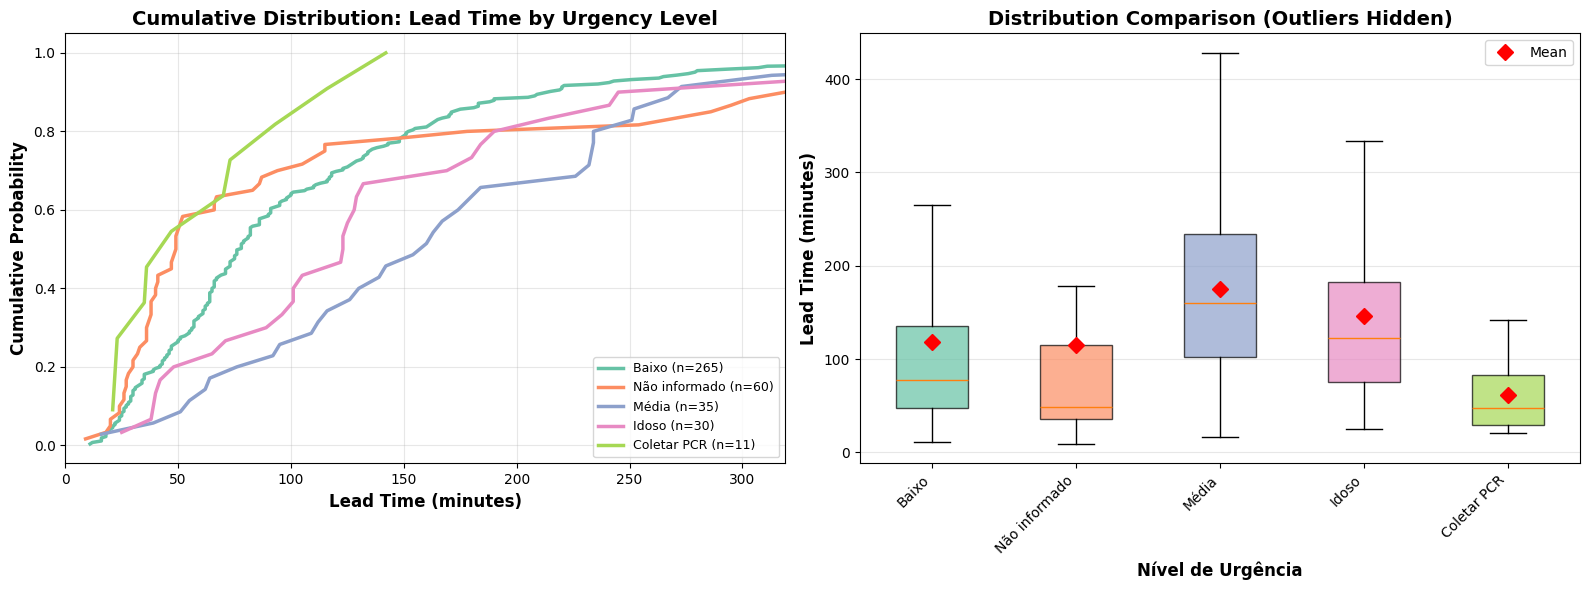


SYNTHESIS - STATISTICAL & BUSINESS SIGNIFICANCE
DESCRIPTIVE STATISTICS:
                     mean     std  count
Nível de Urgência                       
Baixo              118.29  216.79    265
Coletar PCR         61.64   41.10     11
Idoso              146.27  111.02     30
Média              174.51  110.95     35
Não informado      114.67  139.46     60
STATISTICAL SIGNIFICANCE:
  Pairwise comparisons: 10 total
  Significant at p<0.05: 0
  ANOVA p-value (from previous analysis): 0.3523

EPISTEMIC SOUNDNESS:
  Method: Appropriate (Z-test for means, Wasserstein for distributions)
  Sample size: 401 cases with valid lead time
  Segment sizes: 11-265 cases
  High variance: CV ranges 0.64-1.83

BUSINESS SIGNIFICANCE:
  Mean lead time range: 61.6 - 174.5 minutes
  Absolute difference: 112.9 minutes
  Clinical threshold: ~30 minutes (typical ER standard)

CONCLUSION: NOT SIGNIFICANT
  Urgency level does NOT reliably predict case duration
  High within-segment variability masks between-seg

In [589]:
# STEP 1: CASE DURATION ANALYSIS

print(f"\nAnalyzing {len(case_data_filtered)} cases across {len(valid_segments)} segments")
print(f"Segments: {valid_segments}\n")

# Verify lead_time_case exists and has valid data
case_durations = case_data_filtered[['case:concept:name', SEGMENTATION_ATTRIBUTE, 'lead_time_case']].copy()
case_durations = case_durations.dropna(subset=['lead_time_case'])

print(f"Valid cases with lead time data: {len(case_durations)}")

# 1. Pairwise Statistical Tests (Compact)

print("PAIRWISE COMPARISONS (Z-Test & Wasserstein Distance)")

results = []
for seg1, seg2 in combinations(valid_segments, 2):
    d1 = case_durations[case_durations[SEGMENTATION_ATTRIBUTE] == seg1]['lead_time_case']
    d2 = case_durations[case_durations[SEGMENTATION_ATTRIBUTE] == seg2]['lead_time_case']
    
    # Skip if either segment has too few cases
    if len(d1) < 2 or len(d2) < 2:
        continue
    
    # Z-test for means
    z_stat = (d1.mean() - d2.mean()) / np.sqrt(d1.var()/len(d1) + d2.var()/len(d2))
    p_val = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(d1)-1)*d1.var() + (len(d2)-1)*d2.var()) / (len(d1)+len(d2)-2))
    cohens_d = (d1.mean() - d2.mean()) / pooled_std if pooled_std > 0 else 0
    
    # Wasserstein distance
    # w_dist = wasserstein_distance(d1, d2)
    
    results.append({
        'Comparison': f"{seg1[:12]} vs {seg2[:12]}",
        'Mean(min)': f"{d1.mean()-d2.mean():.1f}",
        'Z': f"{z_stat:.2f}",
        'p-value': f"{p_val:.4f}",
        'Sig': 'True' if p_val < 0.05 else 'False',
        'Cohen_d': f"{cohens_d:.2f}",
    })
        #'Wasserstein': f"{w_dist:.1f}"

if len(results) > 0:
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    print(f"\n{results_df['Sig'].value_counts().get('True', 0)}/{len(results_df)} comparisons significant at p<0.05")
else:
    print("Not enough valid segment pairs for comparison")


# 2. Visualization: CDF + Enhanced Box Plot
print("DISTRIBUTION VISUALIZATIONS")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = plt.cm.Set2(range(len(valid_segments)))

# Left: Cumulative Distribution Function (CDF)
for idx, seg in enumerate(valid_segments):
    data = case_durations[case_durations[SEGMENTATION_ATTRIBUTE] == seg]['lead_time_case']
    if len(data) == 0:
        continue
    sorted_data = np.sort(data)
    cumulative = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax1.plot(sorted_data, cumulative, label=f"{seg} (n={len(data)})", lw=2.5, color=colors[idx])

ax1.set_xlabel('Lead Time (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
ax1.set_title('Cumulative Distribution: Lead Time by Urgency Level', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xlim(0, case_durations['lead_time_case'].quantile(0.95))

# Right: Box plot with mean markers
box_data = [case_durations[case_durations[SEGMENTATION_ATTRIBUTE] == seg]['lead_time_case'].values 
            for seg in valid_segments]
bp = ax2.boxplot(box_data, labels=valid_segments, patch_artist=True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

means = [d.mean() for d in box_data if len(d) > 0]
ax2.plot(range(1, len(means)+1), means, 'rD', markersize=8, label='Mean', zorder=3)

ax2.set_xlabel('Nível de Urgência', fontsize=12, fontweight='bold')
ax2.set_ylabel('Lead Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Distribution Comparison (Outliers Hidden)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Statistical & Business Significance Synthesis
print("\nSYNTHESIS - STATISTICAL & BUSINESS SIGNIFICANCE")

# Calculate key metrics
segment_stats = case_durations.groupby(SEGMENTATION_ATTRIBUTE)['lead_time_case'].agg(['mean', 'std', 'count'])
max_mean = segment_stats['mean'].max()
min_mean = segment_stats['mean'].min()
mean_range = max_mean - min_mean

sig_count = results_df['Sig'].value_counts().get('✓', 0) if len(results) > 0 else 0

print(f"DESCRIPTIVE STATISTICS:")
print(segment_stats.round(2))

print(f"STATISTICAL SIGNIFICANCE:")
print(f"  Pairwise comparisons: {len(results)} total")
print(f"  Significant at p<0.05: {sig_count}")
print(f"  ANOVA p-value (from previous analysis): 0.3523")

print(f"\nEPISTEMIC SOUNDNESS:")
print(f"  Method: Appropriate (Z-test for means, Wasserstein for distributions)")
print(f"  Sample size: {len(case_durations)} cases with valid lead time")
print(f"  Segment sizes: {segment_stats['count'].min()}-{segment_stats['count'].max()} cases")
print(f"  High variance: CV ranges {(segment_stats['std']/segment_stats['mean']).min():.2f}-{(segment_stats['std']/segment_stats['mean']).max():.2f}")

print(f"\nBUSINESS SIGNIFICANCE:")
print(f"  Mean lead time range: {min_mean:.1f} - {max_mean:.1f} minutes")
print(f"  Absolute difference: {mean_range:.1f} minutes")
print(f"  Clinical threshold: ~30 minutes (typical ER standard)")

if sig_count == 0:
    print(f"\nCONCLUSION: NOT SIGNIFICANT")
    print(f"  Urgency level does NOT reliably predict case duration")
    print(f"  High within-segment variability masks between-segment differences")
    print(f"  Possible confounders: staffing, time of day, patient complexity")
elif sig_count < len(results) / 2:
    print(f"\nCONCLUSION: MIXED RESULTS")
    print(f"  Only {sig_count}/{len(results)} comparisons significant")
    print(f"  Some urgency pairs show differences, but not systematic")
    print(f"  Segmentation may need refinement (combine categories?)")
else:
    print(f"\nCONCLUSION: SIGNIFICANT")
    print(f"  Majority of comparisons show differences ({sig_count}/{len(results)})")
    if mean_range > 30:
        print(f"  Clinically meaningful: {mean_range:.0f} min exceeds 30-min threshold")
    else:
        print(f"  Statistically but not clinically significant ({mean_range:.0f} min)")


### Step 2: Case Size Analysis (Activity Count)

In [590]:
# STEP 2: CASE SIZE ANALYSIS (Number of Activities per Case)


# Count activities per case from event log
activity_counts = df_merged.groupby('case:concept:name').size().reset_index(name='activity_count')

# Merge with segment information
case_size_data = activity_counts.merge(
    case_data_filtered[['case:concept:name', SEGMENTATION_ATTRIBUTE]],
    on='case:concept:name',
    how='inner'
)

print(f"Analyzed {len(case_size_data)} cases")

# Descriptive statistics per segment
size_stats = case_size_data.groupby(SEGMENTATION_ATTRIBUTE)['activity_count'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("\nActivity Count Statistics by Segment:")
display(size_stats)

# ANOVA Test
print("\nANOVA - COMPARING MEAN ACTIVITY COUNTS")

# Prepare data for ANOVA
groups = [case_size_data[case_size_data[SEGMENTATION_ATTRIBUTE] == seg]['activity_count'].values 
          for seg in valid_segments]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)

# Calculate effect size (Eta-squared)
grand_mean = case_size_data['activity_count'].mean()
ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
ss_total = sum((case_size_data['activity_count'] - grand_mean)**2)
eta_squared = ss_between / ss_total

print(f"Null Hypothesis: Mean activity count is equal across all urgency levels")
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Effect size (Eta Squared): {eta_squared:.3f}")

if p_value < 0.05:
    print(f"\nSIGNIFICANT (p < 0.05): Activity counts DIFFER across urgency levels")
    effect_interpretation = (
        "Large effect" if eta_squared > 0.14 else
        "Medium effect" if eta_squared > 0.06 else
        "Small effect"
    )
    print(f"Effect size: {effect_interpretation} (Eta Squared={eta_squared:.3f})")
else:
    print(f"\nNOT SIGNIFICANT (p ≥ 0.05): Activity counts are similar across urgency levels")
"""

print("\n- CASE COMPLEXITY BY URGENCY")

mean_range = size_stats['mean'].max() - size_stats['mean'].min()

print(f"KEY METRICS:")
print(f"  Activity count range: {size_stats['mean'].min():.1f} - {size_stats['mean'].max():.1f}")
print(f"  Absolute difference: {mean_range:.1f} activities")
print(f"  Overall mean: {case_size_data['activity_count'].mean():.1f} activities/case")

print(f"\nSTATISTICAL SIGNIFICANCE:")
if p_value < 0.05:
    print(f"  SIGNIFICANT: Urgency level correlates with process complexity")
    print(f"  F={f_stat:.2f}, p={p_value:.4f}, Eta Square={eta_squared:.3f}")
else:
    print(f"  NOT SIGNIFICANT: Similar complexity across urgency levels")
    print(f"  F={f_stat:.2f}, p={p_value:.4f}")

print(f"\nBUSINESS INTERPRETATION:")
if mean_range >= 2:
    print(f"  Difference of {mean_range:.1f} activities may indicate:")
    print(f"  Higher urgency --> more diagnostic procedures")
    print(f"  OR lower urgency --> more waiting activities logged")
else:
    print(f"  Uniform process: ~{case_size_data['activity_count'].mean():.0f} activities regardless of urgency")
    print(f"  Standard ER workflow maintained across triage levels")

print(f"\nINSIGHT:")
if p_value < 0.05:
    print(f"  Process complexity (activity count) IS influenced by urgency classification")
else:
    print(f"  All patients go through similar number of steps regardless of urgency")
    print(f"  Triage affects priority/timing, NOT process structure")

    """

Analyzed 401 cases

Activity Count Statistics by Segment:


,count,mean,median,std,min,max
Nível de Urgência,,,,,,
Baixo,265,5.43,4.0,3.10,4,18
Coletar PCR,11,4.91,4.0,1.76,4,10
Idoso,30,8.03,5.0,5.29,4,23
Média,35,13.00,14.0,6.10,4,26
Não informado,60,5.28,4.0,3.30,4,17



ANOVA - COMPARING MEAN ACTIVITY COUNTS
Null Hypothesis: Mean activity count is equal across all urgency levels
F-statistic: 36.49
p-value: 0.0000
Effect size (Eta Squared): 0.269

SIGNIFICANT (p < 0.05): Activity counts DIFFER across urgency levels
Effect size: Large effect (Eta Squared=0.269)


'\n\nprint("\n- CASE COMPLEXITY BY URGENCY")\n\nmean_range = size_stats[\'mean\'].max() - size_stats[\'mean\'].min()\n\nprint(f"KEY METRICS:")\nprint(f"  Activity count range: {size_stats[\'mean\'].min():.1f} - {size_stats[\'mean\'].max():.1f}")\nprint(f"  Absolute difference: {mean_range:.1f} activities")\nprint(f"  Overall mean: {case_size_data[\'activity_count\'].mean():.1f} activities/case")\n\nprint(f"\nSTATISTICAL SIGNIFICANCE:")\nif p_value < 0.05:\n    print(f"  SIGNIFICANT: Urgency level correlates with process complexity")\n    print(f"  F={f_stat:.2f}, p={p_value:.4f}, Eta Square={eta_squared:.3f}")\nelse:\n    print(f"  NOT SIGNIFICANT: Similar complexity across urgency levels")\n    print(f"  F={f_stat:.2f}, p={p_value:.4f}")\n\nprint(f"\nBUSINESS INTERPRETATION:")\nif mean_range >= 2:\n    print(f"  Difference of {mean_range:.1f} activities may indicate:")\n    print(f"  Higher urgency --> more diagnostic procedures")\n    print(f"  OR lower urgency --> more waiting activ

### Step 3: Rework Detection (Repeated Activities)

In [591]:
# STEP 3: REWORK DETECTION - REPEATED ACTIVITIES ANALYSIS

print("\nIdentifying Repeated Activities n")

# Count activity occurrences per case
activity_counts_per_case = (
    df_merged.groupby(['case:concept:name', 'concept:name'])
    .size()
    .reset_index(name='occurrences')
)

# Flag rework (activity appears >1 time in same case)
rework_activities = activity_counts_per_case[activity_counts_per_case['occurrences'] > 1].copy()
rework_activities['is_rework'] = True

# Get total unique cases with rework
cases_with_rework = rework_activities['case:concept:name'].unique()
print(f"Total cases analyzed: {df_merged['case:concept:name'].nunique()}")
print(f"Cases with rework: {len(cases_with_rework)} ({len(cases_with_rework)/df_merged['case:concept:name'].nunique()*100:.1f}%)")

# Merge with segment information
rework_by_segment = rework_activities.merge(
    case_data_filtered[['case:concept:name', SEGMENTATION_ATTRIBUTE]],
    on='case:concept:name',
    how='inner'
)

print(f"\nRework events by segment:")
rework_summary = rework_by_segment.groupby(SEGMENTATION_ATTRIBUTE).agg({
    'case:concept:name': 'nunique',
    'occurrences': 'sum'
}).rename(columns={'case:concept:name': 'cases_with_rework', 'occurrences': 'total_rework_instances'})

# Add total cases per segment for percentage calculation
segment_totals = case_data_filtered.groupby(SEGMENTATION_ATTRIBUTE).size().rename('total_cases')
rework_summary = rework_summary.join(segment_totals)
rework_summary['rework_rate_%'] = (rework_summary['cases_with_rework'] / rework_summary['total_cases'] * 100).round(2)

display(rework_summary)

# Chi-Square Test - Rework Independence
print("\nCHI-SQUARE TEST - REWORK FREQUENCY INDEPENDENCE")

# Create contingency table: Segment vs Rework Status
case_rework_status = case_data_filtered[['case:concept:name', SEGMENTATION_ATTRIBUTE]].copy()
case_rework_status['has_rework'] = case_rework_status['case:concept:name'].isin(cases_with_rework)

contingency_table = pd.crosstab(
    case_rework_status[SEGMENTATION_ATTRIBUTE],
    case_rework_status['has_rework'],
    margins=False
)
contingency_table.columns = ['No Rework', 'Has Rework']

print("\nContingency Table:")
display(contingency_table)

# Perform Chi-square test
chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f"\nNull Hypothesis: Rework occurrence is independent of urgency level")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"\nSIGNIFICANT (p < 0.05): Rework frequency DIFFERS by urgency level")
    print(f"  Some urgency levels are more tends to repeated activities")
else:
    print(f"\nNOT SIGNIFICANT (p ≥ 0.05): Rework frequency is similar across urgency levels")
    print(f"  All urgency levels have comparable rework rates")

# Most Frequently Repeated Activities
print("\nMOST FREQUENTLY REPEATED ACTIVITIES")

# Top rework activities overall
top_rework_activities = (
    rework_by_segment.groupby('concept:name')
    .agg({'case:concept:name': 'nunique', 'occurrences': 'sum'})
    .sort_values('occurrences', ascending=False)
    .head(3)
)
top_rework_activities.columns = ['Cases_Affected', 'Total_Rework_Instances']

print("\nTop 3 Activities with Rework:")
display(top_rework_activities)

# 
print("\n - REWORK PATTERNS BY URGENCY")

max_rework_segment = rework_summary['rework_rate_%'].idxmax()
min_rework_segment = rework_summary['rework_rate_%'].idxmin()
rework_range = rework_summary['rework_rate_%'].max() - rework_summary['rework_rate_%'].min()

overall_rework_rate = len(cases_with_rework) / len(case_data_filtered)

print(f"KEY METRICS:")
print(f"  Overall rework rate: {overall_rework_rate*100:.1f}%")
print(f"  Highest rework: {max_rework_segment} ({rework_summary.loc[max_rework_segment, 'rework_rate_%']:.1f}%)")
print(f"  Lowest rework: {min_rework_segment} ({rework_summary.loc[min_rework_segment, 'rework_rate_%']:.1f}%)")
print(f"  Range: {rework_range:.1f} percentage points")

print(f"\nSTATISTICAL SIGNIFICANCE:")
if p_value < 0.05:
    print(f"  SIGNIFICANT: Rework patterns differ by urgency level")
    print(f"  Chi-square={chi2:.2f}, p={p_value:.4f}")
else:
    print(f"  NOT SIGNIFICANT: Rework rates are similar across urgency levels")
    print(f"  Chi-square={chi2:.2f}, p={p_value:.4f}")

print(f"\nBUSINESS INTERPRETATION:")
if rework_range > 10:
    print(f"  Wide variation ({rework_range:.1f}pp) suggests:")
    print(f"    {max_rework_segment}: Diagnostic uncertainty or complex cases")
    print(f"    {min_rework_segment}: More straightforward treatment paths")
    print(f"  Investigate high-rework segments for process improvement")
else:
    print(f"  Narrow variation ({rework_range:.1f}pp): Consistent process quality")
    print(f"  → Rework driven by clinical necessity, not urgency category")

print(f"\nINSIGHT:")
if p_value < 0.05:
    print(f"  Rework associated with urgency classification.")
    print(f"  Focus improvement efforts on {max_rework_segment} segment.")
else:
    print(f"  Rework occurs uniformly regardless of urgency level.")
    print(f"  Root causes likely systemic (staffing, communication, equipment).")

print(f"\nTOP REWORK ACTIVITIES:")
for activity in top_rework_activities.head(3).index:
    cases = top_rework_activities.loc[activity, 'Cases_Affected']
    print(f"  {activity}: {cases} cases affected")


Identifying Repeated Activities n
Total cases analyzed: 415
Cases with rework: 92 (22.2%)

Rework events by segment:


,cases_with_rework,total_rework_instances,total_cases,rework_rate_%
Nível de Urgência,,,,
Baixo,40,301,265,15.09
Coletar PCR,1,5,11,9.09
Idoso,13,103,30,43.33
Média,27,292,35,77.14
Não informado,7,61,60,11.67



CHI-SQUARE TEST - REWORK FREQUENCY INDEPENDENCE

Contingency Table:


,No Rework,Has Rework
Nível de Urgência,,
Baixo,225,40
Coletar PCR,10,1
Idoso,17,13
Média,8,27
Não informado,53,7



Null Hypothesis: Rework occurrence is independent of urgency level
Chi-square statistic: 82.29
Degrees of freedom: 4
p-value: 0.0000

SIGNIFICANT (p < 0.05): Rework frequency DIFFERS by urgency level
  Some urgency levels are more tends to repeated activities

MOST FREQUENTLY REPEATED ACTIVITIES

Top 3 Activities with Rework:


,Cases_Affected,Total_Rework_Instances
concept:name,,
Medicamentos,70,343
Materiais Hospitalares,69,311
Exames Laboratoriais,26,96



 - REWORK PATTERNS BY URGENCY
KEY METRICS:
  Overall rework rate: 22.9%
  Highest rework: Média (77.1%)
  Lowest rework: Coletar PCR (9.1%)
  Range: 68.0 percentage points

STATISTICAL SIGNIFICANCE:
  SIGNIFICANT: Rework patterns differ by urgency level
  Chi-square=82.29, p=0.0000

BUSINESS INTERPRETATION:
  Wide variation (68.0pp) suggests:
    Média: Diagnostic uncertainty or complex cases
    Coletar PCR: More straightforward treatment paths
  Investigate high-rework segments for process improvement

INSIGHT:
  Rework associated with urgency classification.
  Focus improvement efforts on Média segment.

TOP REWORK ACTIVITIES:
  Medicamentos: 70 cases affected
  Materiais Hospitalares: 69 cases affected
  Exames Laboratoriais: 26 cases affected


# PROCESS DISCOVERY & OUTLIER DETECTION


### Step 1: Baseline Model Discovery - Directly-Follow Graph (DFG)


DFG: 54 edges
 1. Atendimento                Triagem                  :  415
 2. Triagem                    Consulta                 :  411
 3. Medicamentos               Medicamentos             :  325
 4. Materiais Hospitalares     Materiais Hospitalares   :  287
 5. Consulta                   Alta                     :  257
 6. Materiais Hospitalares     Medicamentos             :  124
 7. Exames Laboratoriais       Exames Laboratoriais     :  120
 8. Exames de Imagem           Alta                     :   92
 9. Medicamentos               Materiais Hospitalares   :   90
10. Consulta                   Materiais Hospitalares   :   52


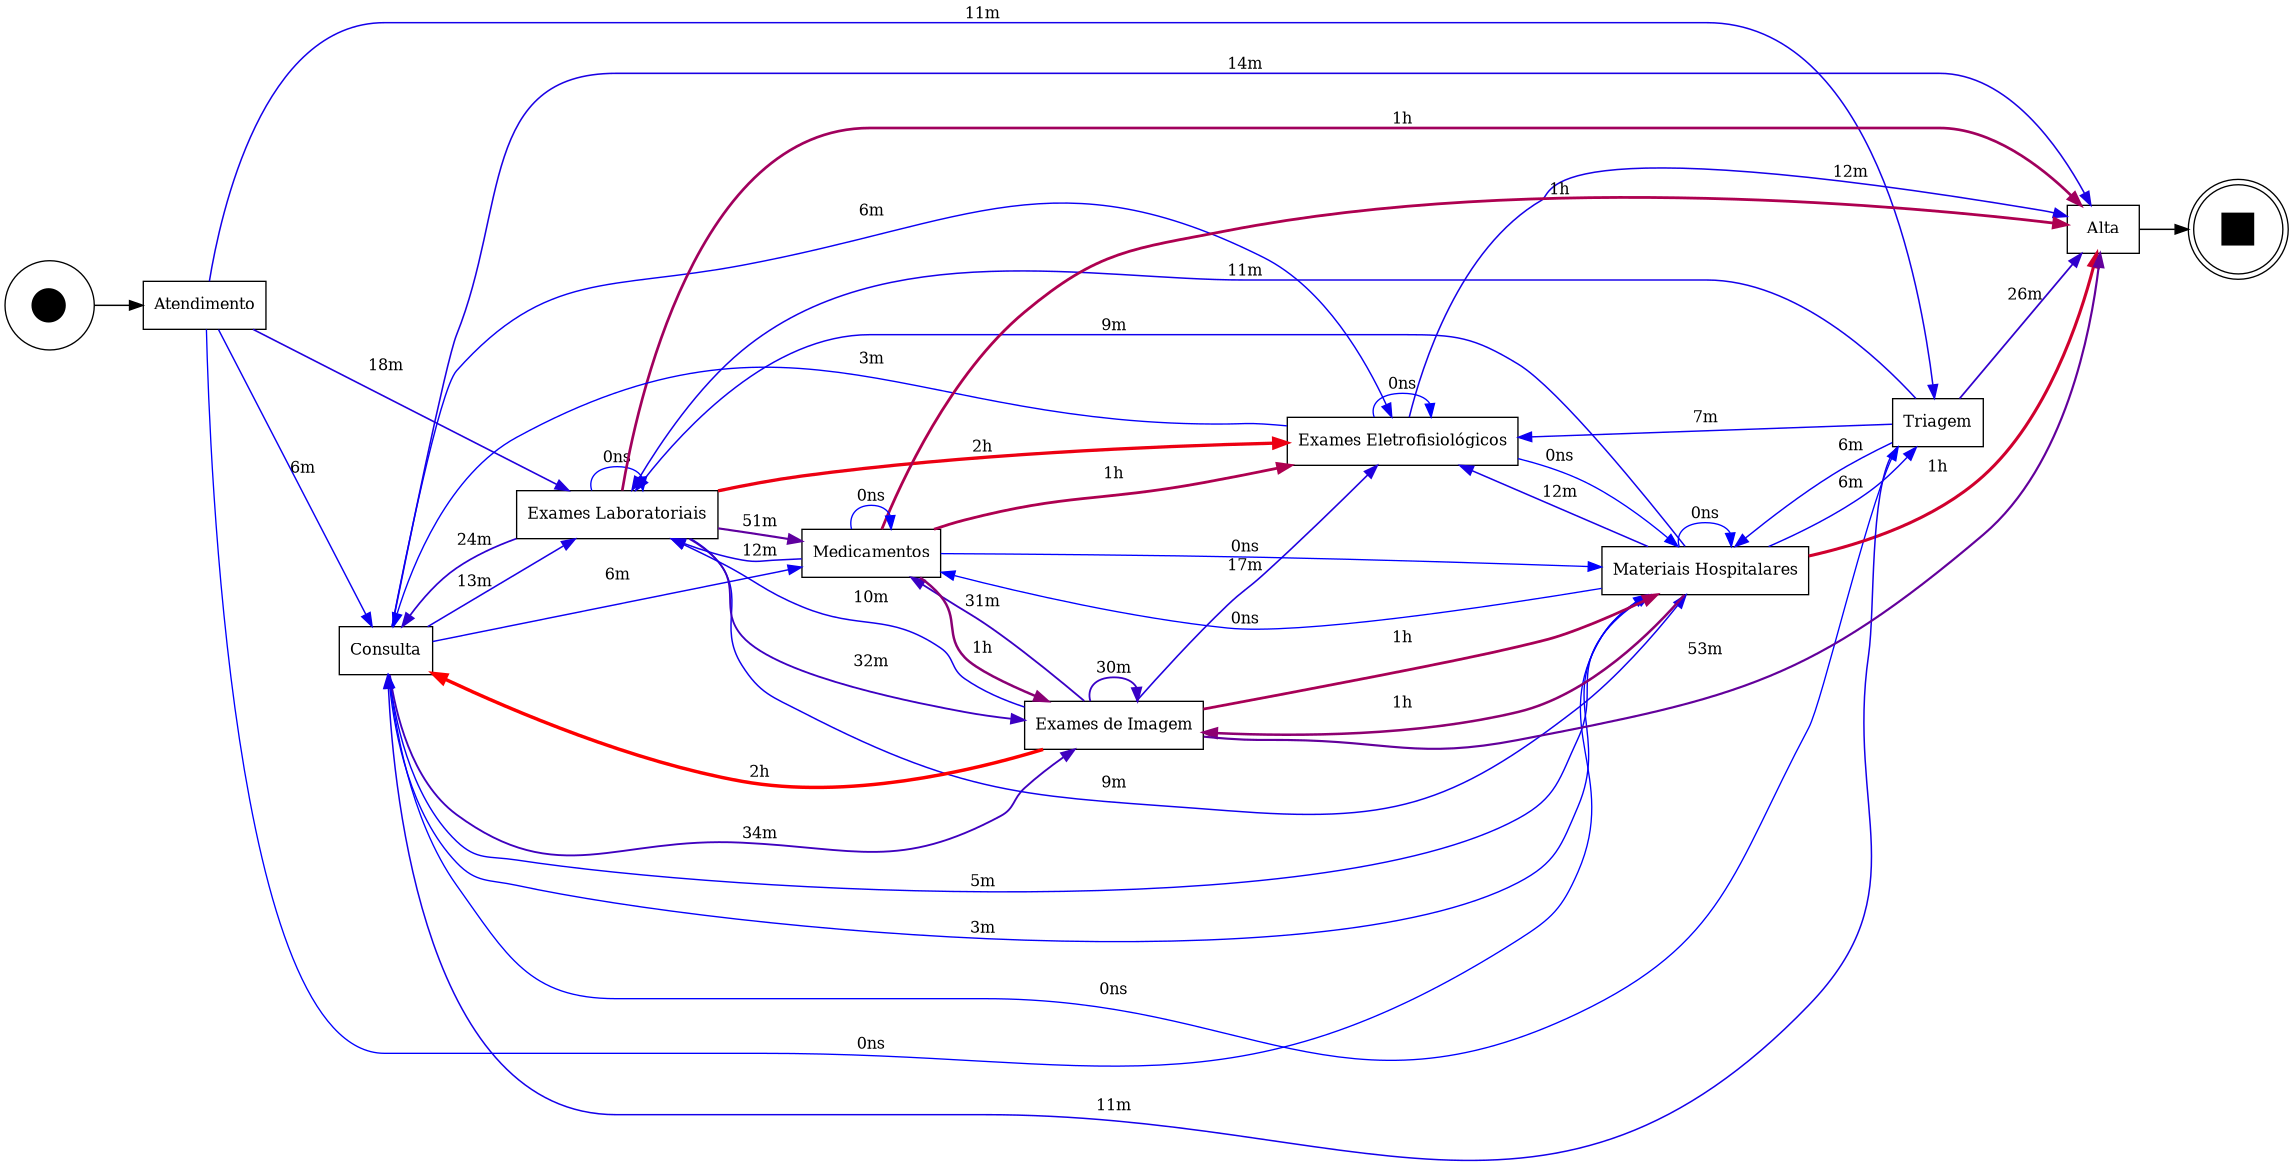

Top 10 Bottlenecks:
 1. Exames de Imagem           Consulta                 :  136.0 min
 2. Exames Laboratoriais       Exames Eletrofisiológicos:  126.0 min
 3. Materiais Hospitalares     Alta                     :  111.0 min
 4. Medicamentos               Alta                     :   93.0 min
 5. Medicamentos               Exames Eletrofisiológicos:   93.0 min
 6. Exames de Imagem           Materiais Hospitalares   :   90.0 min
 7. Exames Laboratoriais       Alta                     :   86.0 min
 8. Materiais Hospitalares     Exames de Imagem         :   75.5 min
 9. Medicamentos               Exames de Imagem         :   74.0 min
10. Exames de Imagem           Alta                     :   53.0 min


In [592]:
# Discover and visualize DFG
dfg, start_acts, end_acts = pm4py.discover_dfg(event_log)

gviz = dfg_visualization.apply(dfg, parameters={
    dfg_visualization.Variants.FREQUENCY.value.Parameters.START_ACTIVITIES: start_acts,
    dfg_visualization.Variants.FREQUENCY.value.Parameters.END_ACTIVITIES: end_acts,
    dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: "png"
})
dfg_visualization.save(gviz, "dfg_baseline_model.png")

print(f"DFG: {len(dfg)} edges")
sorted_dfg = sorted(dfg.items(), key=lambda x: x[1], reverse=True)[:10]
for i, ((source, target), freq) in enumerate(sorted_dfg, 1):
    print(f"{i:2d}. {source:25s}  {target:25s}: {freq:4d}")




# Discover and visualize Performance DFG
performance_dfg, start_activities_perf, end_activities_perf = pm4py.discover_performance_dfg(df)

pm4py.view_performance_dfg(performance_dfg, start_activities_perf, end_activities_perf, 
                           format='png', aggregation_measure='median')

pm4py.save_vis_performance_dfg(performance_dfg, start_activities_perf, end_activities_perf,
                                'performance_dfg_median.png', aggregation_measure='median')

print("Top 10 Bottlenecks:")
bottlenecks = [(s, t, (v.get('median', v) if isinstance(v, dict) else v) / 60) 
               for (s, t), v in performance_dfg.items()]
bottlenecks.sort(key=lambda x: x[2], reverse=True)

for i, (src, tgt, mins) in enumerate(bottlenecks[:10], 1):
    print(f"{i:2d}. {src:25s}  {tgt:25s}: {mins:6.1f} min")

### Step 2: Inductive Miner - Petri Net Discovery


Petri Net: 32 places, 37 transitions
Visible: 9, Tau: 28
High tau ratio - possible overgeneralization (model is flexible but may allow behaviors not in the real process)
Alpha: 6 places, 9 transitions


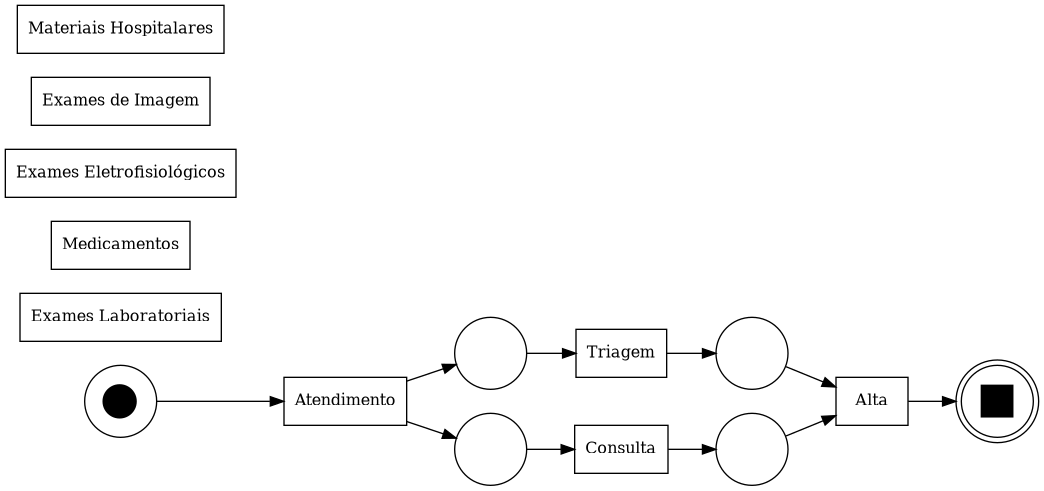

replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

Fitness: 0.9909 Excellent! The model can replay almost all traces from the log, 
 Precision: 0.4743: Lower precision means model allows more behavior than observed


In [593]:
# Discover Process Tree and visualize
process_tree = inductive_miner.apply(event_log)
gviz_pt = pt_visualizer.apply(process_tree)
pt_visualizer.save(gviz_pt, "process_tree_inductive_miner.png")

# Convert to Petri Net
net, initial_marking, final_marking = pt_converter.apply(process_tree)
print(f"Petri Net: {len(net.places)} places, {len(net.transitions)} transitions")

visible_transitions = [t for t in net.transitions if t.label is not None]
tau_transitions = [t for t in net.transitions if t.label is None]
print(f"Visible: {len(visible_transitions)}, Tau: {len(tau_transitions)}")

# Visualize and export Petri Net
gviz_pn = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.save(gviz_pn, "petri_net_inductive_miner.png")
pnml_exporter.apply(net, initial_marking, "petri_net_model.pnml", final_marking=final_marking)

if len(tau_transitions) > len(visible_transitions):
    print("High tau ratio - possible overgeneralization (model is flexible but may allow behaviors not in the real process)")


# Alpha Miner comparison
try:
    net_alpha, im_alpha, fm_alpha = pm4py.discover_petri_net_alpha(
        df, activity_key='concept:name', case_id_key='case:concept:name', 
        timestamp_key='time:timestamp'
    )
    
    print(f"Alpha: {len(net_alpha.places)} places, {len(net_alpha.transitions)} transitions")
    
    pm4py.view_petri_net(net_alpha, im_alpha, fm_alpha, format='png')
    pm4py.save_vis_petri_net(net_alpha, im_alpha, fm_alpha, 'petri_net_alpha_miner.png')
    
    fitness_alpha = replay_fitness.apply(event_log, net_alpha, im_alpha, fm_alpha, 
                                         variant=replay_fitness.Variants.TOKEN_BASED)
    precision_alpha = precision_evaluator.apply(event_log, net_alpha, im_alpha, fm_alpha,
                                                variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    
    print(f"Fitness: {fitness_alpha['average_trace_fitness']:.4f} Excellent! The model can replay almost all traces from the log, \n Precision: {precision_alpha:.4f}: Lower precision means model allows more behavior than observed")
    

except Exception as e:
    print(f"Alpha Miner failed: {str(e)}")

### Step 3: Quality Metrics Computation (DFG + IM)

In [594]:
# Compute quality metrics
print("Final evaluation metrics for the Inductive Miner model.")
fitness_im = replay_fitness.apply(event_log, net, initial_marking, final_marking, 
                                   variant=replay_fitness.Variants.TOKEN_BASED)
precision_im = precision_evaluator.apply(event_log, net, initial_marking, final_marking,
                                         variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
simplicity_im = simplicity_evaluator.apply(net)

fitness_score_im = fitness_im['average_trace_fitness']
precision_score_im = precision_im
f1_score_im = 2 * (precision_score_im * fitness_score_im) / (precision_score_im + fitness_score_im)

# Summary table
metrics_summary = pd.DataFrame({
    'Model': ['Inductive Miner'],
    'Fitness': [f"{fitness_score_im:.4f}"],
    'Precision': [f"{precision_score_im:.4f}"],
    'Simplicity': [f"{simplicity_im:.4f}"],
    'F1 Score': [f"{f1_score_im:.4f}"],
    'Places': [len(net.places)],
    'Transitions': [len(net.transitions)],
    'Trans.': [len(tau_transitions)]
})

display(metrics_summary)
"""
The Inductive Miner achieved perfect fitness (100%) meaning every patient pathway in our data can be replayed
with an F1 score of 0.67 balancing accuracy and precision - 
the moderate precision reflects the inherent variability in emergency room processes where patients follow many different paths

The high number of tau transitions (28) explains the flexibility 
- these silent transitions allow the model to skip or repeat activities as needed

"""

# Interpretation
if fitness_score_im > 0.95 and precision_score_im < 0.5:
    print("\n Flower model detected - high fitness, low precision")
elif fitness_score_im > 0.9 and precision_score_im > 0.7:
    print("\n Balanced model")

Final evaluation metrics for the Inductive Miner model.


replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

,Model,Fitness,Precision,Simplicity,F1 Score,Places,Transitions,Trans.
0,Inductive Miner,1.0000,0.5043,0.6449,0.6705,32,37,28


### Step 4: Variant-Filtered Model Discovery (THE SOLUTION!)

In [595]:
# Determine variants for 80% coverage
if 'cumulative_percentage' not in variant_df.columns:
    variant_df['cumulative_percentage'] = variant_df['percentage'].cumsum()

variants_for_80_pct = variant_df[variant_df['cumulative_percentage'] <= 80.0]
num_variants_80 = len(variants_for_80_pct)

print(f"Variants: {len(variant_df)} → {num_variants_80} (covering {variants_for_80_pct['percentage'].sum():.1f}%)")

# Filter event log to top 80% variants
variants_to_keep_80 = variants_for_80_pct['variant'].tolist()
filtered_log_80 = variants_filter_module.apply(df, variants_to_keep_80)
event_log_80 = pm4py.convert_to_event_log(filtered_log_80)

print(f"Cases: {len(event_log)} → {len(event_log_80)} ({len(event_log_80)/len(event_log)*100:.1f}%)")

# Discover model with filtered log
process_tree_80 = inductive_miner.apply(event_log_80)
net_80, initial_marking_80, final_marking_80 = pt_converter.apply(process_tree_80)

visible_transitions_80 = [t for t in net_80.transitions if t.label is not None]
tau_transitions_80 = [t for t in net_80.transitions if t.label is None]

print(f"Petri Net: {len(net_80.places)} places, {len(net_80.transitions)} transitions ({len(tau_transitions_80)} tau)")

gviz_pn_80 = pn_visualizer.apply(net_80, initial_marking_80, final_marking_80)
pn_visualizer.save(gviz_pn_80, "petri_net_variant_filtered_80pct.png")

# Compute quality metrics on FULL log
fitness_80 = replay_fitness.apply(event_log, net_80, initial_marking_80, final_marking_80, 
                                   variant=replay_fitness.Variants.TOKEN_BASED)
precision_80 = precision_evaluator.apply(event_log, net_80, initial_marking_80, final_marking_80,
                                         variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
simplicity_80 = simplicity_evaluator.apply(net_80)

fitness_score_80 = fitness_80['average_trace_fitness']
precision_score_80 = precision_80
f1_score_80 = 2 * (precision_score_80 * fitness_score_80) / (precision_score_80 + fitness_score_80)

# Comparison table
comparison_metrics = pd.DataFrame({
    'Model': ['IM - Full Log', 'IM - Top 80%'],
    'Fitness': [f"{fitness_score_im:.4f}", f"{fitness_score_80:.4f}"],
    'Precision': [f"{precision_score_im:.4f}", f"{precision_score_80:.4f}"],
    'Simplicity': [f"{simplicity_im:.4f}", f"{simplicity_80:.4f}"],
    'F1 Score': [f"{f1_score_im:.4f}", f"{f1_score_80:.4f}"],
    'Places': [len(net.places), len(net_80.places)],
    'Transitions': [len(net.transitions), len(net_80.transitions)],
    'Trans.': [len(tau_transitions), len(tau_transitions_80)]
})

print("\n" + comparison_metrics.to_string(index=False))

# Improvement analysis
precision_change = precision_score_80 - precision_score_im
fitness_change = fitness_score_80 - fitness_score_im

print(f"\nChanges: Fitness {fitness_change:+.4f}, Precision {precision_change:+.4f}, F1 {f1_score_80 - f1_score_im:+.4f}")

if precision_change > 0.05 and fitness_change > -0.1:
    print(" Variant filtering improved quality")
elif precision_change > 0.05:
    print("Higher precision but lower fitness")

Variants: 111 → 22 (covering 79.9%)
Cases: 443 → 344 (77.7%)
Petri Net: 20 places, 24 transitions (16 tau)


replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]


        Model Fitness Precision Simplicity F1 Score  Places  Transitions  Trans.
IM - Full Log  1.0000    0.5043     0.6449   0.6705      32           37      28
 IM - Top 80%  0.9884    0.7262     0.6875   0.8373      20           24      16

Changes: Fitness -0.0116, Precision +0.2219, F1 +0.1668
 Variant filtering improved quality


K-VALUE OPTIMIZATION


replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/693 [00:00<?, ?it/s]

/tmp/ipykernel_3795/327961841.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_table[['Fitness', 'Precision', 'F1']] = results_table[['Fitness', 'Precision', 'F1']].applymap(lambda x: f"{x:.4f}")



 K Fitness Precision     F1 Coverage %  Places  Transitions
 5  0.9867    0.6574 0.7890      72.2%       9           11
10  0.9870    0.8918 0.9370      74.3%      15           21
15  0.9870    0.8501 0.9135      76.1%      17           22
20  0.9891    0.7665 0.8637      77.2%      18           22
25  0.9884    0.7262 0.8373      78.3%      20           24
30  0.9884    0.7262 0.8373      79.2%      20           24

Best k=10: F1=0.9370 (Δ=+0.2665)


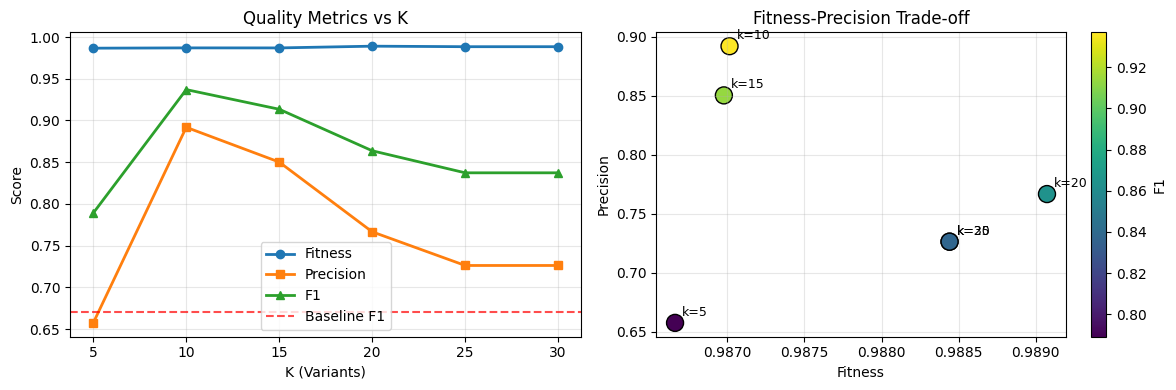

In [596]:

print("K-VALUE OPTIMIZATION")

def find_best_k(log, df_input, k_values):
    """Find optimal k variants maximizing F1 score."""
    results = {}
    
    for k in k_values:
        top_k_variants = variant_df.nsmallest(k, 'variant_index')['variant'].tolist()
        filtered_log_k = variants_filter_module.apply(df_input, top_k_variants)
        event_log_k = pm4py.convert_to_event_log(filtered_log_k)
        
        if len(event_log_k) < 10:
            continue
        
        try:
            process_tree_k = inductive_miner.apply(event_log_k)
            net_k, im_k, fm_k = pt_converter.apply(process_tree_k)
            
            fitness_k = replay_fitness.apply(log, net_k, im_k, fm_k, 
                                            variant=replay_fitness.Variants.TOKEN_BASED)['average_trace_fitness']
            precision_k = precision_evaluator.apply(log, net_k, im_k, fm_k,
                                                   variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            f1_k = 2 * fitness_k * precision_k / (fitness_k + precision_k + 1e-12)
            
            results[k] = {
                "fitness": fitness_k, "precision": precision_k, "f1": f1_k,
                "coverage_pct": (len(event_log_k) / len(log)) * 100,
                "places": len(net_k.places), "transitions": len(net_k.transitions)
            }
        except Exception:
            continue
    
    best_k = max(results, key=lambda k: results[k]['f1']) if results else None
    return {"best_k": best_k, "baseline_f1": f1_score_im, "results": results}

# Run optimization
k_values_to_test = [5, 10, 15, 20, 25, 30]
optimization_results = find_best_k(event_log, df, k_values_to_test)

# Results table
results_table = pd.DataFrame.from_dict(optimization_results['results'], orient='index').reset_index()
results_table.columns = ['K', 'Fitness', 'Precision', 'F1', 'Coverage %', 'Places', 'Transitions']
results_table[['Fitness', 'Precision', 'F1']] = results_table[['Fitness', 'Precision', 'F1']].applymap(lambda x: f"{x:.4f}")
results_table['Coverage %'] = results_table['Coverage %'].apply(lambda x: f"{x:.1f}%")
print("\n" + results_table.to_string(index=False))

if optimization_results["best_k"]:
    best = optimization_results['results'][optimization_results['best_k']]
    print(f"\nBest k={optimization_results['best_k']}: F1={best['f1']:.4f} (Δ={best['f1'] - f1_score_im:+.4f})")

# Single visualization combining metrics and trade-off
import matplotlib.pyplot as plt

k_vals = list(optimization_results['results'].keys())
metrics = optimization_results['results']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Metrics vs K
for metric, marker in [('fitness', 'o'), ('precision', 's'), ('f1', '^')]:
    axes[0].plot(k_vals, [metrics[k][metric] for k in k_vals], f'{marker}-', label=metric.capitalize(), linewidth=2)
axes[0].axhline(y=f1_score_im, color='red', linestyle='--', alpha=0.7, label='Baseline F1')
axes[0].set_xlabel('K (Variants)')
axes[0].set_ylabel('Score')
axes[0].set_title('Quality Metrics vs K')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trade-off scatter
sc = axes[1].scatter([metrics[k]['fitness'] for k in k_vals], 
                     [metrics[k]['precision'] for k in k_vals],
                     s=150, c=[metrics[k]['f1'] for k in k_vals], cmap='viridis', edgecolors='black')
for k in k_vals:
    axes[1].annotate(f'k={k}', (metrics[k]['fitness'], metrics[k]['precision']), 
                     xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1].set_xlabel('Fitness')
axes[1].set_ylabel('Precision')
axes[1].set_title('Fitness-Precision Trade-off')
axes[1].grid(True, alpha=0.3)
plt.colorbar(sc, ax=axes[1], label='F1')

plt.tight_layout()
plt.savefig('k_optimization_analysis.png', dpi=150)
plt.show()

### Step 5: Outlier Detection Using Model Conformance

In [597]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_algo

# Compute per-case fitness
case_fitness_list = []
for trace in event_log:
    case_id = trace.attributes['concept:name']
    single_trace_log = pm4py.objects.log.obj.EventLog([trace])
    trace_fitness = replay_fitness_algo.apply(
        single_trace_log, net_80, initial_marking_80, final_marking_80,
        variant=replay_fitness_algo.Variants.TOKEN_BASED
    )
    case_fitness_list.append({
        'case_id': case_id,
        'fitness': trace_fitness['average_trace_fitness']
    })

case_fitness_df = pd.DataFrame(case_fitness_list)
print(f"Fitness: Mean={case_fitness_df['fitness'].mean():.4f}, Median={case_fitness_df['fitness'].median():.4f}")

# Identify outliers (fitness < 0.7)
FITNESS_THRESHOLD = 0.7
outliers = case_fitness_df[case_fitness_df['fitness'] < FITNESS_THRESHOLD]
print(f"Outliers: {len(outliers)} ({len(outliers)/len(case_fitness_df)*100:.1f}%)")

# Merge with case data
case_fitness_df = case_fitness_df.merge(
    df_merged[['case:concept:name', 'Nível de Urgência', 'variant_index', 
               'lead_time_case', 'total_processing_time']].drop_duplicates(subset=['case:concept:name']),
    left_on='case_id', right_on='case:concept:name', how='left'
)

outliers_full = case_fitness_df[case_fitness_df['fitness'] < FITNESS_THRESHOLD]
conforming_full = case_fitness_df[case_fitness_df['fitness'] >= FITNESS_THRESHOLD]

# Urgency comparison
if len(outliers_full) > 0:
    urgency_comparison = pd.DataFrame({
        'Overall (%)': case_fitness_df['Nível de Urgência'].value_counts(normalize=True) * 100,
        'Outliers (%)': outliers_full['Nível de Urgência'].value_counts(normalize=True) * 100
    }).fillna(0)
    print("\n" + urgency_comparison.round(1).to_string())
    
    # Performance comparison
    perf_comparison = pd.DataFrame({
        'Metric': ['Lead Time (min)', 'Processing Time (min)'],
        'Conforming': [conforming_full['lead_time_case'].mean(), conforming_full['total_processing_time'].mean()],
        'Outliers': [outliers_full['lead_time_case'].mean(), outliers_full['total_processing_time'].mean()]
    })
    perf_comparison['Difference'] = perf_comparison['Outliers'] - perf_comparison['Conforming']
    print("\n" + perf_comparison.round(2).to_string(index=False))
    
    # Export outliers
    outliers_sorted = outliers_full.sort_values('fitness')[
        ['case_id', 'fitness', 'Nível de Urgência', 'variant_index', 'lead_time_case']
    ]
    print(f"\nTop 10 Most Deviant Cases:")
    print(outliers_sorted.head(10).to_string(index=False))
    
    outliers_sorted.to_csv('outlier_cases.csv', index=False)
    print(f"Exported: 'outlier_cases.csv' ({len(outliers_sorted)} cases)")
else:
    print("No outliers detected")

Fitness: Mean=0.9884, Median=1.0000
Outliers: 2 (0.5%)

                         Overall (%)  Outliers (%)
Nível de Urgência                                 
Baixo                           63.9           0.0
Coletar PCR                      2.7           0.0
Dor Torácica                     1.2           0.0
Gestante                         1.2           0.0
Idoso                            7.2           0.0
Média                            8.4           0.0
Não informado                   14.5           0.0
Portador de deficiência          0.7           0.0
Sem prioridade - Azul            0.2           0.0

               Metric  Conforming  Outliers  Difference
      Lead Time (min)      124.18       NaN         NaN
Processing Time (min)      124.18       NaN         NaN

Top 10 Most Deviant Cases:
case_id  fitness Nível de Urgência  variant_index  lead_time_case
5452132 0.625000               NaN            NaN             NaN
5462968 0.666667               NaN            NaN     

### Step 6: Timeline & Visual Analysis (NEW)


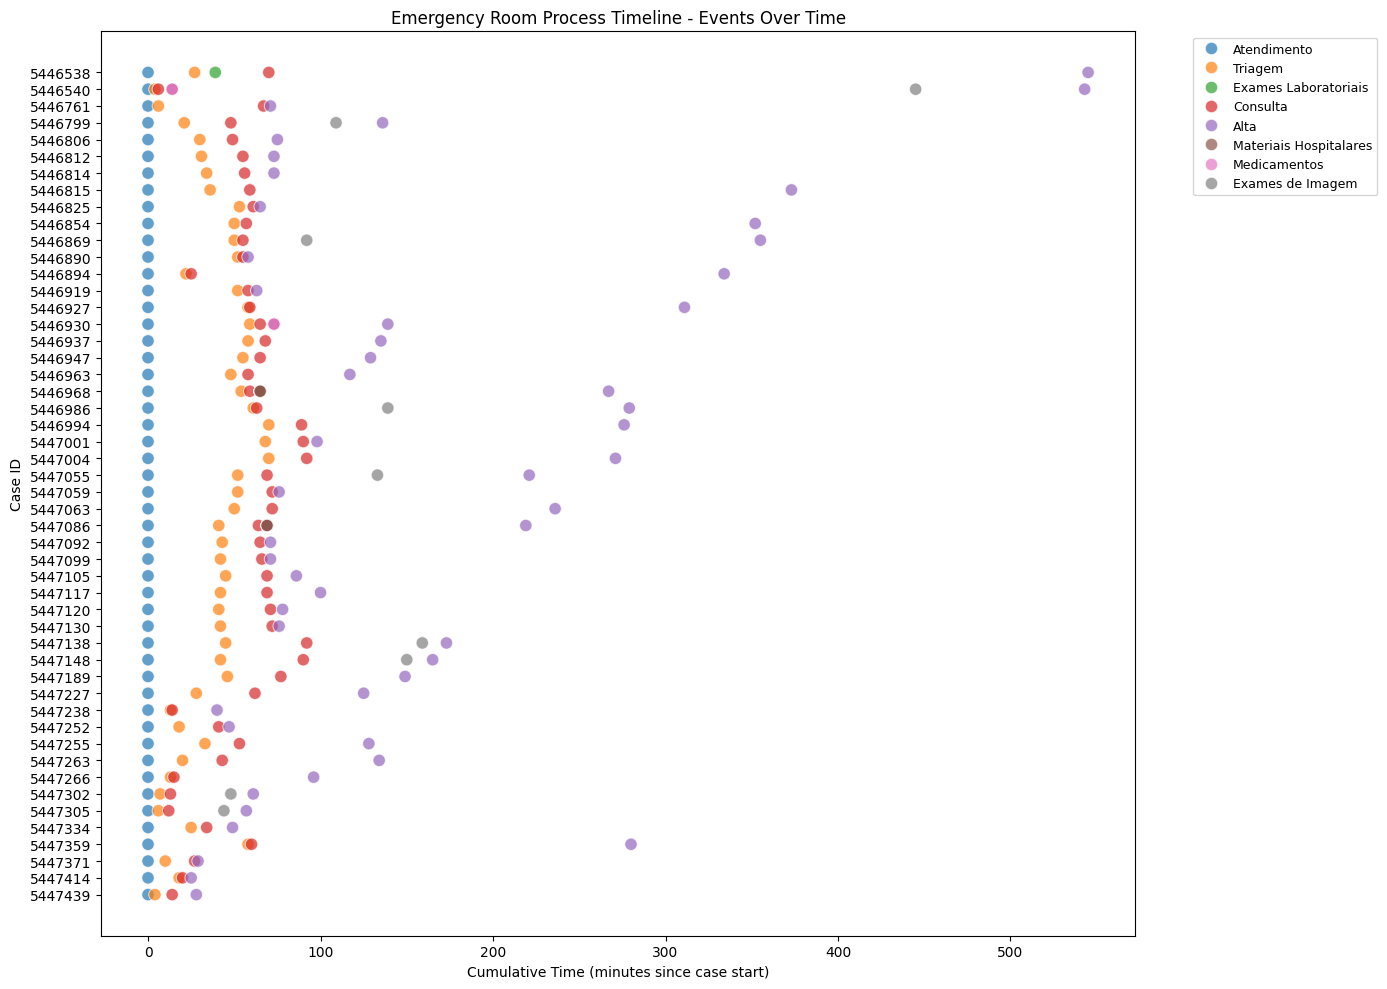

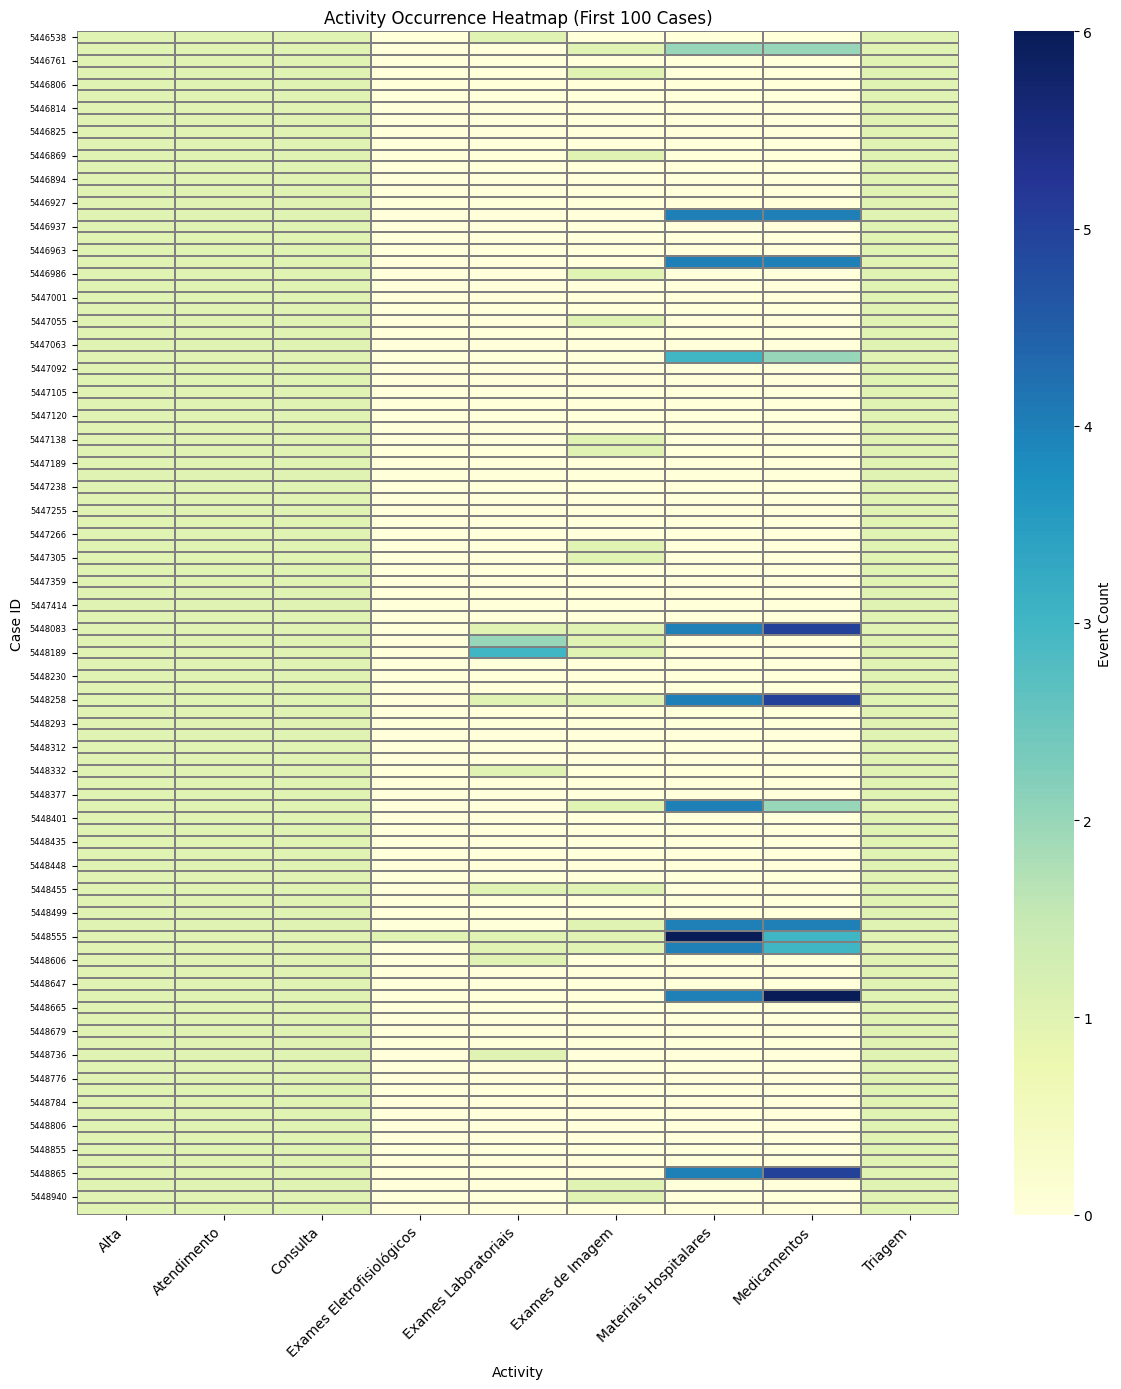

Avg activities per case: 6.3

Top 5 Activities:
concept:name
Atendimento     415
Alta            415
Consulta        415
Triagem         413
Medicamentos    365


In [598]:
# Calculate cumulative time for each event
case_times = df_merged.groupby('case:concept:name')['time:timestamp'].agg(['min', 'max']).reset_index()
case_times.columns = ['case:concept:name', 'case_start', 'case_end']

df_timeline = df_merged.merge(case_times, on='case:concept:name')
df_timeline['cumulative_minutes'] = (df_timeline['time:timestamp'] - df_timeline['case_start']).dt.total_seconds() / 60

# Timeline scatter plot
sample_cases = df_timeline['case:concept:name'].unique()[:50]
df_timeline_sample = df_timeline[df_timeline['case:concept:name'].isin(sample_cases)]

fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=df_timeline_sample, x='cumulative_minutes', y='case:concept:name', 
                hue='concept:name', s=80, alpha=0.7, ax=ax)
ax.set_xlabel('Cumulative Time (minutes since case start)')
ax.set_ylabel('Case ID')
ax.set_title('Emergency Room Process Timeline - Events Over Time')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('timeline_scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# Event occurrence heatmap
case_activity_matrix = pd.crosstab(df_merged['case:concept:name'], df_merged['concept:name'])
case_activity_sample = case_activity_matrix.iloc[:100]

fig, ax = plt.subplots(figsize=(12, 14))
sns.heatmap(case_activity_sample, cmap='YlGnBu', cbar_kws={'label': 'Event Count'}, 
            ax=ax, linewidths=0.1, linecolor='gray')
ax.set_xlabel('Activity')
ax.set_ylabel('Case ID')
ax.set_title('Activity Occurrence Heatmap (First 100 Cases)')
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('case_activity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Activity pattern analysis
avg_activities_per_case = df_merged.groupby('case:concept:name')['concept:name'].count().mean()
print(f"Avg activities per case: {avg_activities_per_case:.1f}")
print(f"\nTop 5 Activities:")
print(df_merged['concept:name'].value_counts().head(5).to_string())

### Step 7: Conformance Diagnostics (Token-Based Replay)


In [599]:
from scipy.stats import kruskal

print("Conformance Diagnostics (Token-Based Replay)")

# Token-based replay diagnostics
tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(
    df, net_80, initial_marking_80, final_marking_80
)
diagnostics_df = pd.DataFrame(tbr_diagnostics)

print(f"Trace fitness: Mean={diagnostics_df['trace_fitness'].mean():.4f}, "
      f"Median={diagnostics_df['trace_fitness'].median():.4f}, "
      f"Min={diagnostics_df['trace_fitness'].min():.4f}")

# Fitness distribution
perfect_fit = (diagnostics_df['trace_fitness'] == 1.0).sum()
good_fit = ((diagnostics_df['trace_fitness'] >= 0.9) & (diagnostics_df['trace_fitness'] < 1.0)).sum()
poor_fit = (diagnostics_df['trace_fitness'] < 0.7).sum()

print(f"Perfect (1.0): {perfect_fit} ({perfect_fit/len(diagnostics_df)*100:.1f}%), "
      f"Good (0.9-1.0): {good_fit} ({good_fit/len(diagnostics_df)*100:.1f}%), "
      f"Poor (<0.7): {poor_fit} ({poor_fit/len(diagnostics_df)*100:.1f}%)")

# Token analysis
if 'missing_tokens' in diagnostics_df.columns:
    cases_with_missing = diagnostics_df[diagnostics_df['missing_tokens'] > 0]
    print(f"\nCases with missing tokens: {len(cases_with_missing)} ({len(cases_with_missing)/len(diagnostics_df)*100:.1f}%)")
    if len(cases_with_missing) > 0:
        print("\nTop 5 Missing Tokens:")
        print(cases_with_missing.nlargest(5, 'missing_tokens')[
            ['trace_fitness', 'missing_tokens', 'consumed_tokens']].to_string())

# Link with urgency level
case_ids_list = [trace.attributes['concept:name'] for trace in event_log]

# Ensure lengths match
min_len = min(len(case_ids_list), len(diagnostics_df))
case_ids_list = case_ids_list[:min_len]
diagnostics_df = diagnostics_df.iloc[:min_len].copy()

diagnostics_df['case_id'] = case_ids_list

case_segment_data = df_merged[['case:concept:name', 'Nível de Urgência']].drop_duplicates()
diagnostics_with_segment = diagnostics_df.merge(
    case_segment_data, left_on='case_id', right_on='case:concept:name', how='left'
)

diagnostics_clean = diagnostics_with_segment.dropna(subset=['Nível de Urgência'])

urgency_conformance = diagnostics_clean.groupby('Nível de Urgência').agg({
    'trace_fitness': ['mean', 'median', 'std', 'count']
}).round(4)
urgency_conformance.columns = ['Mean Fitness', 'Median Fitness', 'Std Dev', 'Count']

print("\nConformance by Urgency:")
print(urgency_conformance.to_string())

worst_urgency = diagnostics_clean.groupby('Nível de Urgência')['trace_fitness'].mean().idxmin()
print(f"\nWorst conformance: {worst_urgency} ({diagnostics_clean.groupby('Nível de Urgência')['trace_fitness'].mean().min():.4f})")

# Statistical test
urgency_groups = diagnostics_clean.groupby('Nível de Urgência')['trace_fitness'].apply(list).values
if len(urgency_groups) >= 2 and all(len(g) >= 5 for g in urgency_groups):
    stat, p_value = kruskal(*urgency_groups)
    print(f"\nKruskal-Wallis: H={stat:.2f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference in conformance across urgency levels")

Conformance Diagnostics (Token-Based Replay)


replaying log with TBR, completed traces ::   0%|          | 0/88 [00:00<?, ?it/s]

Trace fitness: Mean=0.9979, Median=1.0000, Min=0.9000
Perfect (1.0): 399 (96.1%), Good (0.9-1.0): 16 (3.9%), Poor (<0.7): 0 (0.0%)

Cases with missing tokens: 16 (3.9%)

Top 5 Missing Tokens:
     trace_fitness  missing_tokens  consumed_tokens
351       0.907719               6               55
295       0.915968               5               54
347       0.900000               3               30
137       0.957937               2               36
149       0.965645               2               44

Conformance by Urgency:
                         Mean Fitness  Median Fitness  Std Dev  Count
Nível de Urgência                                                    
Baixo                          0.9975             1.0   0.0126    254
Coletar PCR                    1.0000             1.0   0.0000      9
Dor Torácica                   1.0000             1.0   0.0000      5
Gestante                       1.0000             1.0   0.0000      5
Idoso                          1.0000             1

#  Identify potential improvements

### Step 1: Setup and Import Target Variable

In [600]:
# Extract last activity per case as target variable
last_activity_per_case = (
    filtered_log.groupby('case:concept:name')['concept:name']
    .last()
    .rename('LastActivity')
)

# Merge back to log
filtered_log = filtered_log.merge(
    last_activity_per_case,
    left_on='case:concept:name',
    right_index=True,
    how='left'
)

# Check target distribution
print("Target Variable Distribution:")
print(filtered_log.groupby('case:concept:name')['LastActivity'].first().value_counts())

Target Variable Distribution:
LastActivity
Alta                         415
Exames Eletrofisiológicos      1
Exames Laboratoriais           1
Exames de Imagem               1
Name: count, dtype: int64


### Step 2: Add Case-Level Features

In [601]:
# Calculate case lead time (minutes)
filtered_log['LeadTime'] = (
    filtered_log.groupby('case:concept:name')['time:timestamp']
    .transform(lambda s: (s.max() - s.min()).total_seconds() / 60)
)

# Time between consecutive events (minutes)
filtered_log['EventLeadTime'] = (
    filtered_log.groupby('case:concept:name')['time:timestamp']
    .diff()
    .dt.total_seconds() / 60
)

# Verify features
print(f"LeadTime range: {filtered_log['LeadTime'].min():.1f} - {filtered_log['LeadTime'].max():.1f} min")
print(f"Cases: {filtered_log['case:concept:name'].nunique()}")

LeadTime range: 9.0 - 3221.0 min
Cases: 418


###  STEP 3: Rename Columns for pm4py

In [602]:
# Rename to case-level attributes
filtered_log = filtered_log.rename(columns={
    'LeadTime': 'case:LeadTime',
    'LastActivity': 'case:LastActivity'
})

print("Columns ready for ML:")
print([col for col in filtered_log.columns if col.startswith('case:')])

Columns ready for ML:
['case:concept:name', 'case:LastActivity', 'case:LeadTime']


### STEP 4: Generate Prefixes

In [603]:
# Generate prefixes up to length 5 (adjust if needed)
trimmed_df = pm4py.get_prefixes_from_log(filtered_log, length=5)

print(f"Generated {len(trimmed_df)} prefix events")
print(f"Original events: {len(filtered_log)}")
print(f"Expansion factor: {len(trimmed_df) / len(filtered_log):.1f}x")

Generated 1841 prefix events
Original events: 2678
Expansion factor: 0.7x


### Step 5: Extract ML Features

In [604]:
# Extract features
features_df = pm4py.extract_features_dataframe(
    trimmed_df,
    [],  # String case attributes (add if needed)
    ['LeadTime'],  # Numeric case attributes
    ['concept:name'],  # Event activities (one-hot encoded)
    [],  # Numeric event attributes
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp',
    include_case_id=True
)

print(f"Feature matrix shape: {features_df.shape}")
print(f"Features created: {features_df.shape[1] - 1}")  # -1 for case ID

Feature matrix shape: (418, 11)
Features created: 10


### STEP 6: Merge Target Variable

In [605]:
# Get target mapping
last_activity_mapping = filtered_log.groupby('case:concept:name')['case:LastActivity'].first()

# Merge target
features_df = features_df.merge(
    last_activity_mapping,
    left_on='case:concept:name',
    right_index=True,
    how='left'
)

print("\nTarget distribution in training data:")
print(features_df['case:LastActivity'].value_counts())


Target distribution in training data:
case:LastActivity
Alta                         415
Exames Eletrofisiológicos      1
Exames Laboratoriais           1
Exames de Imagem               1
Name: count, dtype: int64


### Step 7: Prepare ML Data

In [606]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Get urgency from original log FIRST
urgency_mapping = filtered_log.groupby('case:concept:name')['Nível de Urgência'].first()

# Merge urgency to features (BEFORE dropping case ID)
features_with_urgency = features_df.merge(
    urgency_mapping, 
    left_on='case:concept:name', 
    right_index=True, 
    how='left'
)

# NOW drop case ID
df_numeric = features_with_urgency.drop(columns=["case:concept:name"])

# Filter valid urgency levels (≥10 samples)
urgency_counts = df_numeric['Nível de Urgência'].value_counts()
print("Urgency distribution:")
print(urgency_counts)

valid_urgencies = urgency_counts[urgency_counts >= 10].index
df_filtered = df_numeric[df_numeric['Nível de Urgência'].isin(valid_urgencies)]

print(f"\nFiltered to {len(df_filtered)} samples with valid urgency levels")

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_filtered['Nível de Urgência'])
y_labels = label_encoder.classes_

# Features (drop both urgency and last activity)
X = df_filtered.drop(columns=['Nível de Urgência', 'case:LastActivity'])

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Target classes: {list(y_labels)}")

Urgency distribution:
Nível de Urgência
Baixo                      265
Não informado               60
Média                       35
Idoso                       30
Coletar PCR                 12
Dor Torácica                 7
Gestante                     5
Portador de deficiência      3
Sem prioridade - Azul        1
Name: count, dtype: int64

Filtered to 402 samples with valid urgency levels

Training samples: 321
Test samples: 81
Target classes: ['Baixo', 'Coletar PCR', 'Idoso', 'Média', 'Não informado']


### Step 8: Define & Train Models

In [607]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

results = {}

for name, model in models.items():
    print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1_w = f1_score(y_test, preds, average='weighted')
    f1_m = f1_score(y_test, preds, average='macro')
    
    results[name] = {"Accuracy": acc, "F1-Weighted": f1_w, "F1-Macro": f1_m}
    
    print(f"Accuracy: {acc:.4f} | F1-Weighted: {f1_w:.4f} | F1-Macro: {f1_m:.4f}")
    print(f"\n{classification_report(y_test, preds, target_names=y_labels, zero_division=0)}")


Training LogisticRegression...
Accuracy: 0.2222 | F1-Weighted: 0.1390 | F1-Macro: 0.2932

               precision    recall  f1-score   support

        Baixo       0.50      0.02      0.04        53
  Coletar PCR       1.00      0.33      0.50         3
        Idoso       0.17      0.50      0.25         6
        Média       0.27      0.57      0.36         7
Não informado       0.20      0.75      0.32        12

     accuracy                           0.22        81
    macro avg       0.43      0.43      0.29        81
 weighted avg       0.43      0.22      0.14        81


Training RandomForest...
Accuracy: 0.5556 | F1-Weighted: 0.5466 | F1-Macro: 0.2833

               precision    recall  f1-score   support

        Baixo       0.71      0.74      0.72        53
  Coletar PCR       0.00      0.00      0.00         3
        Idoso       0.17      0.17      0.17         6
        Média       0.25      0.29      0.27         7
Não informado       0.27      0.25      0.26      

### Step 9: Confusion Matrix

Best Model: RandomForest


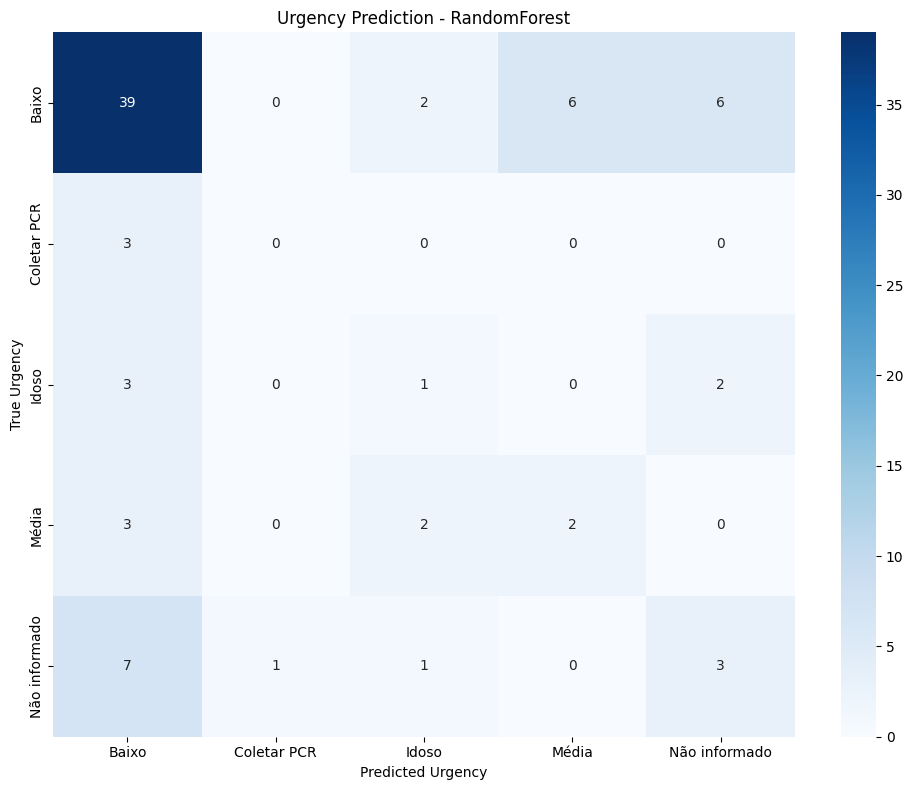

In [608]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Select best model
best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")

# Confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=y_labels, yticklabels=y_labels)
plt.title(f'Urgency Prediction - {best_model_name}')
plt.ylabel('True Urgency')
plt.xlabel('Predicted Urgency')
plt.tight_layout()
plt.show()

### Step 10: Feature Importance

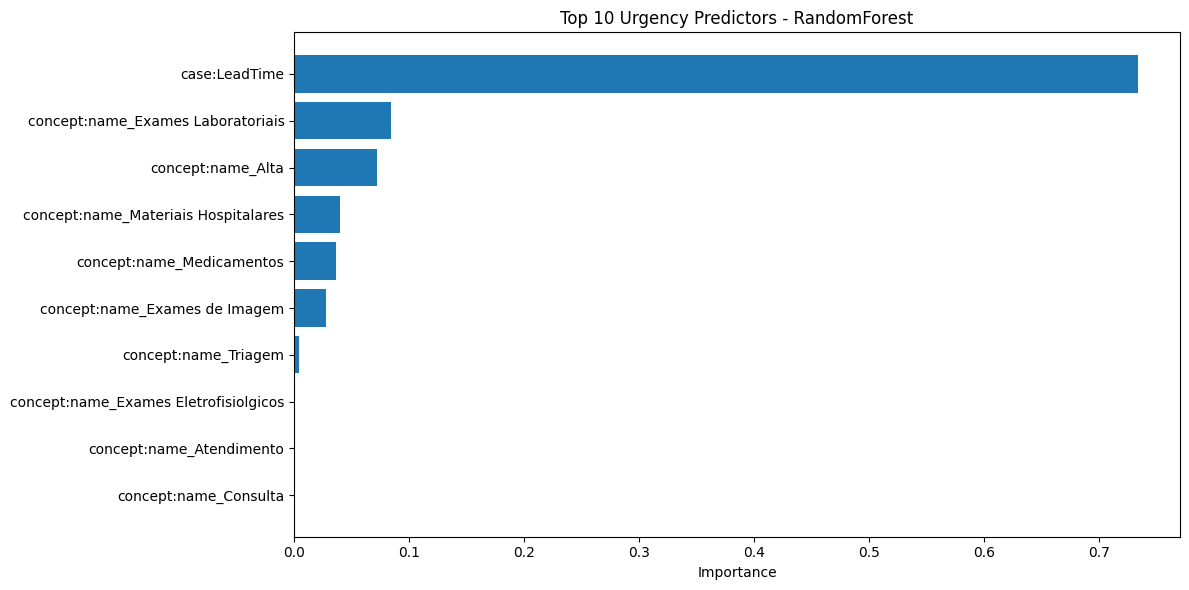


Top 10 Predictive Features:
                                 feature  importance
0                          case:LeadTime    0.733921
5      concept:name_Exames Laboratoriais    0.084617
1                      concept:name_Alta    0.072083
7    concept:name_Materiais Hospitalares    0.039616
8              concept:name_Medicamentos    0.036857
6          concept:name_Exames de Imagem    0.028030
9                   concept:name_Triagem    0.004296
4  concept:name_Exames Eletrofisiolgicos    0.000579
2               concept:name_Atendimento    0.000000
3                  concept:name_Consulta    0.000000


In [609]:
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feat_imp['feature'], feat_imp['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Urgency Predictors - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Predictive Features:")
    print(feat_imp)

### Step 11: Predict Lead Time (Regression)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Data prep
df_numeric = features_df.drop(columns=["case:concept:name", "case:LastActivity"])

# Target: LeadTime (minutes)
X = df_numeric.drop(columns=["case:LeadTime"])
y = df_numeric["case:LeadTime"]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Models
models_reg = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Custom metric
def mean_absolute_log_error(y_true, y_pred):
    return np.mean(np.abs(np.log1p(y_true) - np.log1p(y_pred)))

results_reg = {}

# Train
for name, model in models_reg.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    male = mean_absolute_log_error(y_test, preds)
    
    results_reg[name] = {"MAE": mae, "RMSE": rmse, "R²": r2, "MALE": male}
    
    print(f"{name}:")
    print(f"  MAE: {mae:.2f} min | RMSE: {rmse:.2f} min | R²: {r2:.3f}")

print("\n", pd.DataFrame(results_reg).T)



""" 
Interpretation:

MAE ~66 minutes: On average, predictions are off by about 1 hour
RMSE ~105 minutes: Larger errors exist (some predictions off by ~1.75 hours)
R² ~0.25: Models explain only 25% of variance in lead time

"""

LinearRegression:
  MAE: 66.24 min | RMSE: 104.73 min | R²: 0.250
RandomForest:
  MAE: 65.73 min | RMSE: 105.25 min | R²: 0.243

                         MAE        RMSE        R²      MALE
LinearRegression  66.236465  104.727642  0.250261  0.585380
RandomForest      65.728320  105.252653  0.242725  0.582686


### Step 12: SHAP Analysis (Explain Predictions)


Top Features Contributing to Longer Wait Times:


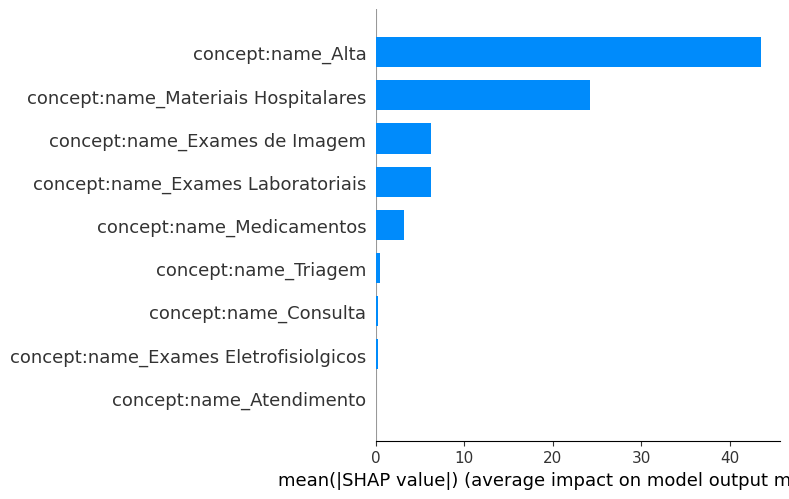

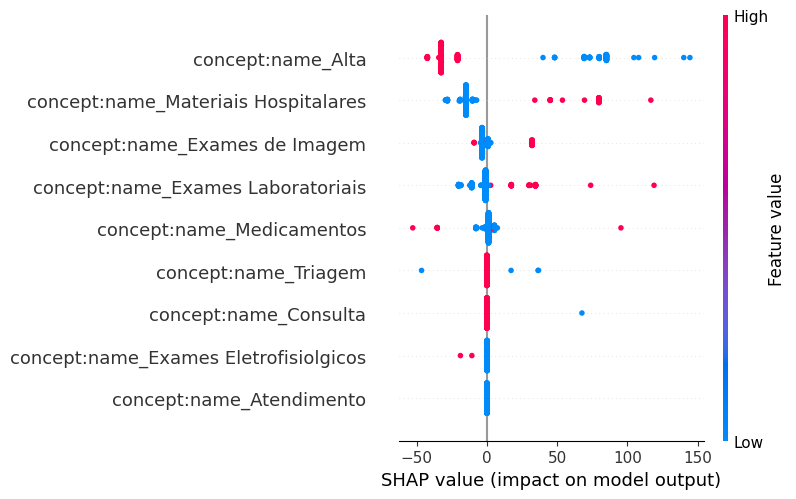

In [611]:
import shap

# Best model (use the one that already exists)
best_model_reg = models_reg["RandomForest"]

# SHAP explainer (use X_train since model was trained on it)
X_for_shap = pd.DataFrame(X_train, columns=X.columns)
explainer = shap.Explainer(best_model_reg, X_for_shap)
shap_values = explainer(X_for_shap)

# Global feature importance
print("Top Features Contributing to Longer Wait Times:")
shap.summary_plot(shap_values, X_for_shap, plot_type="bar")

# Detailed impact plot
shap.summary_plot(shap_values, X_for_shap)